# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Overview and Table of Content

The notebook will implement this workflow:

1. [Prepare jupyter lab notebook environment](#Prepare-jupyter-lab-notebook-environment)
1. [Download Data](#Download-Data)
1. [Data exploration and cleaning](#Data-exploration-and-cleaning)
    1. [Load data from S3](##Load-data-from-S3)
    1. explore the data
    1. [Class Cleaner](#Class-Cleaner)
    1. [Data Cleaning- (handling null and empty values, unknown values, encode categorical values)](#Data-Cleaning) 
    1. [Feature Engineering](#Feature-Engineering)    
1. [Part 1: Customer Segmentation Report](#Part-1:-Customer-Segmentation-Report)
    1. Feature engineering (PCA)
1. [Part 2: Supervised Learning Model](#Part-2:-Supervised-Learning-Model)
    1. Develop a model
    1. Train a model
    1. Model validation and evaluation
    1. Hyperparameters tuning
    1. Select the best performing model based on the test results
1. [Deploy model](#Deploy-Model)

# Prepare jupyter lab notebook environment
---


In [1]:
!python --version

Python 3.7.10


## Update Conda Packages

In [2]:
!conda update -y --force-reinstall conda

Solving environment: / 
  - defaults/linux-64::six-1.15.0-py37h06a4308_0, defaults/linux-64::tenacity-6.3.1-py37h06a4308_0, defaults/noarch::plotly-5.1.0-pyhd3eb1b0_0
  - defaults/linux-64::plotly-3.6.1-py37_0, defaults/linux-64::retrying-1.3.3-py37_2, defaults/noarch::six-1.16.0-pyhd3eb1b0done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            1_gnu          22 KB
    autovizwidget-0.18.0       |     pyhd3eb1b0_0          14 KB
    ca-certificates-2021.7.5   |       h06a4308_1         113 KB
    certifi-2021.5.30          |   py37h06a4308_0         139 KB
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    cryptography-3.4.7         |   py37hd23ed53_0         904 KB
    hdijupyterutils-0.19.0     |     pyhd3eb1b0_0          10 KB
    idna-

In [3]:
! conda update -y conda

Solving environment: - 
  - defaults/linux-64::six-1.15.0-py37h06a4308_0, defaults/linux-64::tenacity-6.3.1-py37h06a4308_0, defaults/noarch::plotly-5.1.0-pyhd3eb1b0_0
  - defaults/linux-64::plotly-3.6.1-py37_0, defaults/linux-64::retrying-1.3.3-py37_2, defaults/noarch::six-1.16.0-pyhd3eb1b0done

# All requested packages already installed.



In [4]:
! conda update --force-reinstall --all -y

Solving environment: | 
  - defaults/linux-64::six-1.15.0-py37h06a4308_0, defaults/linux-64::tenacity-6.3.1-py37h06a4308_0, defaults/noarch::plotly-5.1.0-pyhd3eb1b0_0
  - defaults/linux-64::plotly-3.6.1-py37_0, defaults/linux-64::retrying-1.3.3-py37_2, defaults/noarch::six-1.16.0-pyhd3eb1b0done

## Package Plan ##

  environment location: /opt/conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anaconda-client-1.8.0      |   py37h06a4308_0         150 KB
    anaconda-project-0.10.1    |     pyhd3eb1b0_0         218 KB
    anyio-2.2.0                |   py37h06a4308_1         123 KB
    appdirs-1.4.4              |     pyhd3eb1b0_0          12 KB
    argon2-cffi-20.1.0         |   py37h27cfd23_1          46 KB
    asn1crypto-1.4.0           |             py_0          80 KB
    astroid-2.6.6              |   py37h06a4308_0         311 KB
    astropy-4.3.1              |   py37h09021b7

In [5]:
! conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
aiobotocore               1.4.1                    pypi_0    pypi
aiohttp                   3.7.4.post0              pypi_0    pypi
aioitertools              0.8.0                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda-client           1.8.0            py37h06a4308_0  
anaconda-project          0.10.1             pyhd3eb1b0_0  
anyio                     2.2.0            py37h06a4308_1  
appdirs                   1.4.4              pyhd3eb1b0_0  
argh                      0.26.2                   py37_0  
argon2-cffi               21.1.0                   pypi_0    pypi
asn1crypto                1.4.0                      py_0  
astroid                   2.7.3                    pypi_0    pypi
astropy             

In [6]:
! conda install -y pyarrow scikit-learn-intelex -c districtdatalabs yellowbrick -c conda-forge xgboost imbalanced-learn

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyarrow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-4.0.1            |   py37hced866c_3         7.0 MB
    aws-c-common-0.4.57        |       he6710b0_1         156 KB
    aws-c-event-stream-0.1.6   |       h2531618_5          25 KB
    aws-checksums-0.1.9        |       he6710b0_0          49 KB
    aws-sdk-cpp-1.8.185        |       hce553d0_0         1.9 MB
    boost-cpp-1.73.0           |      h27cfd23_11          25 KB
    double-conversion-3.1.5    |       he6710b0_1         235 KB
    gflags-2.2.2               |       he6710b0_0         126 KB
    glog-0.5.0     

In [7]:
! conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
aiobotocore               1.4.1                    pypi_0    pypi
aiohttp                   3.7.4.post0              pypi_0    pypi
aioitertools              0.8.0                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda-client           1.8.0            py37h06a4308_0  
anaconda-project          0.10.1             pyhd3eb1b0_0  
anyio                     2.2.0            py37h06a4308_1  
appdirs                   1.4.4              pyhd3eb1b0_0  
argh                      0.26.2                   py37_0  
argon2-cffi               21.1.0                   pypi_0    pypi
arrow-cpp                 4.0.1            py37hced866c_3  
asn1crypto                1.4.0                      py_0  
astroid                   

## Auto Reload Modules 
configure auto-reload of modules when they have been changed - this simplifies developing and testing

In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

## Imports and global configs

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_theme()

In [11]:
# display the N columns and rows
pd.set_option('display.max_columns', 50)

pd.set_option('display.max_rows', 100)

## Activate intelex for scikit
see [activate intelex for scikit](https://intel.github.io/scikit-learn-intelex/index.html)

In [12]:
! conda install -y scikit-learn-intelex

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - scikit-learn-intelex


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    daal4py-2021.3.0           |   py37hae6d005_0         8.6 MB
    dal-2021.3.0               |     h06a4308_557        39.2 MB
    llvmlite-0.34.0            |   py37h269e1b5_4         297 KB
    mpi-1.0                    |            mpich          13 KB
    mpich-3.3.2                |       hc856adb_0         3.8 MB
    numba-0.51.2               |   py37h04863e7_1         3.2 MB
    python-3.7.10              |       h12debd9_4  

# Download Data
---
The four data sets
- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).
    
and two files of description    
- `DIAS Attributes - Values 2017.xlsx`
- `DIAS Information Levels - Attributes 2017.xlsx`

can be downloaded from the Udacity project workspace.

# Data exploration and cleaning
---

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load Data from S3
The load script assumes that the downloaded data has been transferred to S3.

The data load of the AZDIAS data set takes more than a minute the CUSTOMERS data set should be loaded in less than 20 secs


In [45]:
import os
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    prefix = 's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'

In [14]:
! aws s3 ls s3://sagemaker-eu-central-1-292575554790/dsnd_arvato/

2021-08-26 12:23:24          0 
2021-08-26 12:23:57      79449 DIAS Attributes - Values 2017.xlsx
2021-08-26 12:23:57      32798 DIAS Information Levels - Attributes 2017.xlsx
2021-08-26 12:23:56  681624835 Udacity_AZDIAS_052018.csv
2021-08-26 12:23:56  144487786 Udacity_CUSTOMERS_052018.csv
2021-08-26 12:23:56   31968574 Udacity_MAILOUT_052018_TEST.csv
2021-08-26 12:23:56   32122983 Udacity_MAILOUT_052018_TRAIN.csv
2021-09-14 20:49:36     556698 bauerst_prediction_2021_09_14_01.csv
2021-09-15 15:43:11     714776 bauerst_prediction_2021_09_15-pipe4-01.csv
2021-09-15 15:59:00     714772 bauerst_prediction_2021_09_15-pipe5-01.csv


In [46]:
%%time
df_azdias = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
# load in the data
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1321: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 25 s, sys: 4.52 s, total: 29.5 s
Wall time: 52.7 s


In [47]:
%%time
df_customers = pd.read_csv(f'{prefix}/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')

CPU times: user 5.23 s, sys: 502 ms, total: 5.73 s
Wall time: 10.1 s


In [48]:
df_azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [49]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.4+ GB


In [50]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Columns: 368 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(8)
memory usage: 539.5+ MB


## Checks 


### Data errors during load
during the load process we got two error messages for columns 18 and 19. I will check this here

In [51]:
# column 18 has 0-based index 17
df_azdias.iloc[:,17].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [52]:
# column 19 has 0-based index 18
df_customers.iloc[:,18].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [53]:
df_azdias.columns[17:19]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


**Result:** The errors is caused by string values "X" and "XX" in the datasets in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.

I will add some code to the Data Cleaner class to handle this


### check for duplicates
check if dataset contains duplicate records based on column ID LNR

In [54]:
df_azdias.index.duplicated().sum()

0

In [55]:
df_customers.index.duplicated().sum()

0

## Loading & Explore Metadata

### Load Metadata

In [56]:
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')
df_metadata.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


### Explore Metadata

1. check nulls
2. check unkown values

In [57]:
df_metadata.isnull().sum()

Attribute      0
Description    0
Value          0
Meaning        0
dtype: int64

In [58]:
f"Number of unique attributes: {df_metadata['Attribute'].unique().shape[0]}"

'Number of unique attributes: 314'

In [59]:
f"Number of Attributes that can be unnkown value: {df_metadata['Meaning'].str.contains('unknown').sum()}"

'Number of Attributes that can be unnkown value: 233'

In [60]:
f"Number of Attributes that can be `no transaction known` value: {df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}"

'Number of Attributes that can be `no transaction known` value: 56'

In [61]:
f"Total: {df_metadata['Meaning'].str.contains('unknown').sum() + df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}"

'Total: 289'

### Metadata Summary

The value *"unkown"* will be treated like a missing value.

The value *"no transaction(s) known"* will be treated as if the customer has done no transaction


## Compare dataset features (columns)

In [62]:
# columns that customers dataset contain but azidas not
set(df_customers.columns) - set(df_azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [63]:
# columns that azdias dataset contain but customers not
set(df_azdias.columns) - set(df_customers.columns)

set()

**Result**: `CUSTOMERS` dataset has 3 more columns {'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

### Metadata Columns compared to Dataset columns

check for which columns of the dataset a metadata description exists

In [64]:
df_metadata_cols = df_metadata['Attribute'].copy()
# some columns of the metadata ends on _RZ whereas the datasets have the same columns whcih do not end on _RZ
# therefore we replace this
df_metadata_cols = df_metadata_cols.str.replace('_RZ','')

diff_set = set(df_azdias.columns) - set(df_metadata_cols)
print(f'number of cols in AZDIAS dataset but not described in Metadata: {len(diff_set)}')
pd.Series(list(diff_set)).sort_values().unique()

number of cols in AZDIAS dataset but not described in Metadata: 60


array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BUCH_CD',
       'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_DATUM',
       'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
       'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM',
       'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP',
       'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
       'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ',
       'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER',
       'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT',
   

In [65]:
diff_set2 = set(df_metadata_cols) - set(df_azdias.columns)
print(f'number of cols in Metadata but not in AZDIAS dataset: {len(diff_set2)}')
diff_set2

number of cols in Metadata but not in AZDIAS dataset: 9


{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BUCH',
 'D19_KK_KUNDENTYP',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [66]:
df_azdias[list(diff_set)].head()

,VK_DHT4A,RT_UEBERGROESSE,VHA,VK_DISTANZ,KBA13_ANTG1,CJT_TYP_4,KONSUMZELLE,UNGLEICHENN_FLAG,DSL_FLAG,RT_SCHNAEPPCHEN,...,CJT_TYP_6,KBA13_KMH_210,D19_TELKO_ONLINE_QUOTE_12,CJT_TYP_2,KBA13_BAUMAX,CJT_KATALOGNUTZER,KBA13_ANTG3,KBA13_GBZ,D19_VERSI_OFFLINE_DATUM,ALTER_KIND1
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,1.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,...,5.0,NaN,NaN,1.0,NaN,5.0,NaN,NaN,10,NaN
910220,8.0,5.0,0.0,11.0,2.0,3.0,1.0,1.0,1.0,3.0,...,1.0,4.0,NaN,5.0,2.0,1.0,2.0,4.0,10,NaN
910225,9.0,5.0,0.0,9.0,2.0,3.0,0.0,0.0,1.0,4.0,...,2.0,4.0,0.0,4.0,1.0,2.0,1.0,4.0,10,NaN
910226,7.0,3.0,1.0,10.0,2.0,4.0,0.0,0.0,1.0,2.0,...,3.0,2.0,0.0,2.0,1.0,3.0,1.0,4.0,10,NaN
910241,3.0,5.0,0.0,5.0,1.0,4.0,0.0,0.0,1.0,5.0,...,3.0,3.0,0.0,3.0,2.0,3.0,2.0,3.0,7,NaN


### Value Checks
some checks to see which values have been used and if they match the values defined in Metadata dataset. I will run several times the investigate_values to check which columns contain values that have to be corrected

In [36]:
# function to investigate column values
def investigate_values(values_to_find=[], cols_to_ignore=[]):
    value_set = set()
    cols_matching_search = []
    for col in df_azdias.columns:    
            if not col in cols_to_ignore:
                col_set = set(df_azdias[col].unique())        
                if any(val in values_to_find for val in col_set):
                    print(col)
                    cols_matching_search.append(col)
                value_set = value_set | col_set
            
    return value_set, cols_matching_search


In [37]:
vs, cols = investigate_values(cols_to_ignore=['EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan']

array(['0', '1', '2', ..., '13', '7E', '-1'], dtype='<U32')

There are several floats - let's find out whicht columns contain that 

In [38]:
vs, cols = investigate_values([86.0,91.0],cols_to_ignore=['EINGEFUEGT_AM'])
np.array(list(vs))[:100]

ANZ_HAUSHALTE_AKTIV
ANZ_STATISTISCHE_HAUSHALTE
KBA13_ANZAHL_PKW


array(['0', '1', '2', '3', 'nan', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0', 'nan', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0',
       '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0',
       '24.0', '25.0', '26.0', '27.0', '28.0', 'nan', 'nan', 'nan', 'nan',
       'nan', 'nan', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0',
       '35.0', '36.0', '37.0', '38.0', '39.0', '40.0', '41.0', '42.0',
       '43.0', '44.0', '45.0', '46.0', '47.0', '48.0', '49.0', '50.0',
       '51.0', '52.0', '53.0', '54.0', '55.0', '56.0', '57.0', '58.0',
       '59.0', '60.0', '61.0', '62.0', '63.0', '64.0', '65.0', '66.0',
       '67.0', '68.0', '69.0', '70.0', '71.0', '72.0', '73.0', '74.0',
       '75.0', '76.0', '77.0', '78.0', '79.0', '80.0', '81.0', '82.0',
       '83.0', '84.0', '85.0', '86.0', '88.0', '87.0', '90.0', '91.0',
       '92.0'], dtype='<U32')

In [39]:
vs, cols = investigate_values(cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan']

array(['0', '1', '2', '3', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0',
       '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0',
       '26.0', '29.0', '27.0', '35.0', '37.0', '38.0', '40.0', '45.0',
       '5D', '43.0', '44.0', 'D19_TELKO_REST', '50.0', '51.0', '52.0',
       '53.0', '54.0', '55.0', '2', '56.0', '49.0', 'D19_SONSTIGE', '8C',
       '41', '28.0', 'X', '30.0', '6', '32.0', '33.0', '34.0', '9C',
       '36.0', '39.0', '41.0', '42.0', 'W', 'D19_BANKEN_DIREKT', '46.0',
       '7C', 'D19_SCHUHE', '47.0', 'D19_LEBENSMITTEL', 'D19_ENERGIE',
       '48.0', '6A', '32', 'D19_REISEN', '5F', 'D19_GARTEN', '55', '8B',
       '31', '44', '4E', '24', '3A', 'D19_SAMMELARTIKEL', '1E',
       'D19_BANKEN_GROSS', 'D19_VERSICHERUNGEN', '54', '9B', 'XX', '5A',
       '5', 'D19_VERSAND_REST', 'O', '6F', 'D19_FREIZEIT', '33', '6D',
       '2B', '43', '3B', '2C', '4', '3D', 'D19_HANDWERK', '12', '34',
       '7B

In [40]:
vs, cols = investigate_values(['D19_LEBENSMITTEL', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_UNBEKANNT', 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 1939, 2001,2001.0,2000.0],cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan'][:50]

D19_LETZTER_KAUF_BRANCHE
EINGEZOGENAM_HH_JAHR
GEBURTSJAHR
MIN_GEBAEUDEJAHR


array(['0', '1', '2', '3', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0',
       '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0',
       '26.0', '29.0', '27.0', '35.0', '37.0', '38.0', '40.0', '45.0',
       '5D', '43.0', '44.0', 'D19_TELKO_REST', '50.0', '51.0', '52.0',
       '53.0', '54.0', '55.0', '2', '56.0', '49.0', 'D19_SONSTIGE', '8C',
       '41'], dtype='<U32')

**Result** Fix for EINGEZOGENAM_HH_JAHR, GEBURTSJAHR and MIN_GEBAEUDEJAHR required. Convert to int and impute missing values

In [41]:
vs, cols = investigate_values(cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE', 'GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','CAMEO_DEU_2015'])
vals = np.array(list(vs))
vals[vals!='nan']


array(['0', '1', '2', '3', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0',
       '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0',
       '26.0', '29.0', '27.0', '35.0', '37.0', '38.0', '40.0', '45.0',
       '15', '41.0', '43.0', '44.0', '46.0', '51.0', '52.0', '48.0',
       '54.0', '55.0', '2', '49.0', '50.0', '53.0', '56.0', '41', '28.0',
       'X', '30.0', '6', '32.0', '33.0', '34.0', '36.0', '39.0', '42.0',
       '1', 'W', '47.0', '14', '8', '32', '9', '23', '55', '31', '44',
       '24', '45', '35', '54', '52', 'XX', '5', 'O', '51', '22', '7', '3',
       '25', '33', '31.0', '43', '13', '4', '12', '34', '-1'],
      dtype='<U32')

In [42]:
vs, cols = investigate_values([18.0,48.0,'XX','X',51],cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE', 'GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','CAMEO_DEU_2015'])
vals = np.array(list(vs))
vals[vals!='nan']


ALTER_HH
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
ANZ_HH_TITEL
ANZ_PERSONEN
CAMEO_DEUG_2015
CAMEO_INTL_2015
EXTSEL992
LP_LEBENSPHASE_FEIN
VERDICHTUNGSRAUM


array(['0', '1', '2', '3', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0',
       '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0',
       '26.0', '29.0', '27.0', '35.0', '37.0', '38.0', '40.0', '45.0',
       '15', '41.0', '43.0', '44.0', '46.0', '51.0', '52.0', '48.0',
       '54.0', '55.0', '2', '49.0', '50.0', '53.0', '56.0', '41', '28.0',
       'X', '30.0', '6', '32.0', '33.0', '34.0', '36.0', '39.0', '42.0',
       '1', 'W', '47.0', '14', '8', '32', '9', '23', '55', '31', '44',
       '24', '45', '35', '54', '52', 'XX', '5', 'O', '51', '22', '7', '3',
       '25', '33', '31.0', '43', '13', '4', '12', '34', '-1'],
      dtype='<U32')

### Extract `Kinder` information and build new feature
we use the ANZ_KINDER and ALTER_KIND(n) columns to derive the number of children <10 and >= 10

number of records with more than 4 children: 252 of 891,221 (0.02828 %)
number of records with at least one child: 86480 of 891,221 (9.70354 %)
number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: 9

--------------------------------------------------------------------------------


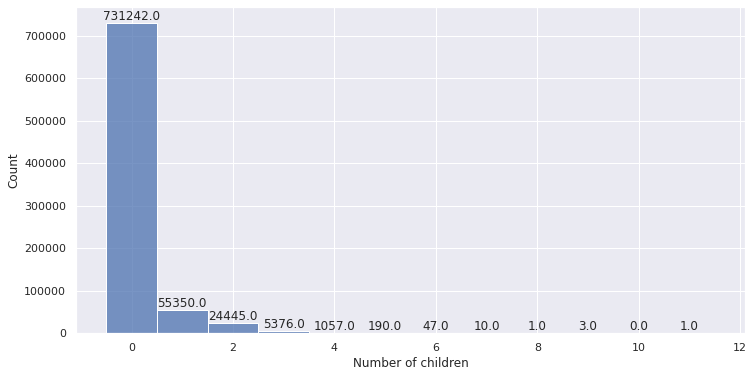

In [43]:
num_moreThan4Children = df_azdias[df_azdias['ANZ_KINDER']>4].shape[0]
num_withChildren = df_azdias[df_azdias['ANZ_KINDER']>0].shape[0]
df_children5plus = df_azdias[(df_azdias['ANZ_KINDER']>4) & (df_azdias['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_azdias.shape[0]:,.0f} ({(num_moreThan4Children / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_azdias.shape[0]:,.0f} ({(num_withChildren / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)

plt.figure(figsize=(12,6))
ax = sns.histplot(data=df_azdias['ANZ_KINDER'], discrete=True)
#ax.set_yscale('log')
ax.set_xlabel('Number of children')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')
plt.show()

**Result** The query above shows that there just 9 records with more or equal than 5 children and an age of child4 (`ALTER_KIND4`) < 10. In addition the `ALTER_KIND` column values are ordered so we can assume that the age of child5 and higher is >= 10

In [44]:
num_moreThan4Children = df_customers[df_customers['ANZ_KINDER']>4].shape[0]
num_withChildren = df_customers[df_customers['ANZ_KINDER']>0].shape[0]
df_children5plus = df_customers[(df_customers['ANZ_KINDER']>4) & (df_customers['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_customers.shape[0]:,.0f} ({(num_moreThan4Children / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_customers.shape[0]:,.0f} ({(num_withChildren / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)



number of records with more than 4 children: 54 of 191,652 (0.02818 %)
number of records with at least one child: 12772 of 191,652 (6.66416 %)
number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: 2

--------------------------------------------------------------------------------


## Class Cleaner


The code for the ETL Pipeline is outsourced to python module ==> see python module etl.processor

In [143]:
import python.etl.processor as etlp
import python.etl.plot as plot

## Data Cleaning


The `DataCleaner` class will handle the following:

* replace `unknown` values (represented by -1, 0, 9 see [Metadata Descriptions](#Loading-and-Explore-Metadata))
* handle the errors raised during the load
* handle categorical variables
* drop not needed columns

see sections below for details

In [67]:
TESTING = False
if TESTING:
    df_azdias_cleaned = df_azdias.iloc[:100,:].copy()
else:
    df_azdias_cleaned = df_azdias.copy()


In [68]:
df_azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.5+ GB


### Handle Unknown / Missing Data

The dataset contains a lot of unkown values. Many times these values are encoded by -1, 0 or 9 (see Metadata files). I replace all unkown values by np.NaN to use standard pandas function for imputinig and dropping.



In [210]:
df_azdias_cleaned.shape

(891221, 365)

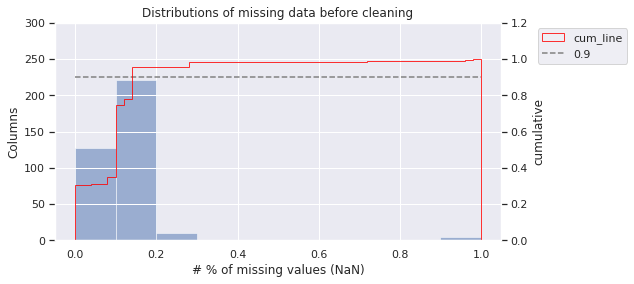

In [211]:
plot.Plot.print_null_dist(df_azdias)

Most columns have less than 25% missing values. Some columns have more than 50% missing data. Let's find them

In [212]:
num_of_records = df_azdias_cleaned.shape[0]
s_missing_data = df_azdias_cleaned.isnull().sum(axis=0)
s_missing_data_pct = df_azdias_cleaned.isnull().sum(axis=0) / num_of_records 

df_missing_data = pd.DataFrame({'abs':s_missing_data,'pct':s_missing_data_pct})
df_missing_data.sort_values(by='pct', ascending=False)[:20]


,abs,pct
ALTER_KIND4,890016,0.998648
ALTER_KIND3,885051,0.993077
ALTER_KIND2,861722,0.966900
ALTER_KIND1,810163,0.909048
EXTSEL992,654153,0.733996
KK_KUNDENTYP,584612,0.655967
ALTERSKATEGORIE_FEIN,262947,0.295041
D19_LETZTER_KAUF_BRANCHE,257113,0.288495
D19_GESAMT_ONLINE_QUOTE_12,257113,0.288495
D19_SOZIALES,257113,0.288495


**Results**: 
* There 16 variables with more than 25% missing values -> These are candidates to drop
* There are some variables that have all the same number of missing data (257113 - D19_...).
* the variables `ALTER_KIND1` - `ALTER_KIND4` have a huge number of missing values. This is because they are dependent on `ANZ_KINDER` (number of children) so that for all records with `ANZ_KINDER`=0 the values for `ALTER_KIND1`- `ALTER_KIND4` are missing. We will handle this in feature engineering part and build a new varaible for these


**Note**: The drop operation will be the last part as columns maybe needed during the feature engineering process


WE can also remove ALTER_HH, KBA05_BAUMAX, AGER_TYP, TITEL_KZ as these have a lot of -1, 0 ,9 values which mean unkown

In [213]:
drop_level = 0.25
columns_to_drop = s_missing_data_pct.sort_values(ascending=False)
columns_to_drop = columns_to_drop[columns_to_drop>drop_level].index
columns_to_drop

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992',
       'KK_KUNDENTYP', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_LOTTO',
       'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_BANKEN_ONLINE_QUOTE_12'],
      dtype='object')

### Inverstigate  columns that throw an error
Info: just a copy from above [Data error during load](#Data-errors-during-load)

In [214]:
df_azdias_cleaned['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

Obviously the 'X' is causing the issue. I will replace this by np.NaN

In [215]:
df_azdias_cleaned['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

Obviously the 'XX' is causing the issue. I will replace this by np.NaN

### Handle Categorical Values

The datasets have a huge number of categorical variables. Most of the categorical variables are already encoded by int and floats, e.g. `AGER_TYP` is encoded by

|value  | meaning |
|-----  |---------|
|-1     |	unknown |
|0	    | no classification possible |
|1	    | passive elderly |
|2	    | cultural elderly |
|3	    | experience-driven elderly |

We keep this encoding as in many cases the categorical values are Ordinal and just some nominal, e.g.

variable `D19_TELKO_ANZ_12` the values are ordered from `very low activity` to `very high activity`

|value  | meaning |
|-----  |---------|
|0      | no transactions known            |
|1      | very low activity                |
|2      | low activity                     |
|3      | slightly increased activity      |
|4      | increased activity               |
|5      | high activity                    |
|6      | very high activity               |


However, some columns are of type = object. These are now investigated.

In [216]:
df_azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.5+ GB


In [217]:
df_azdias_cleaned.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN
910220,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
910225,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
910226,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
910241,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


#### Results Categorical:

|variable   | type      | action    |
|--         |--         | ---   	|
|CAMEO_DEU_2015| nominal | drop - this column seems to be based on not real measurable feature |
|D19_LETZTER_KAUF_BRANCHE | nominal | replace by one hot encoding |
| EINGEFUEGT_AM | date | drop - this is just the date when the record has been added |
| OST_WEST_KZ | nominal | replace by binary 0 and 1 |

`CAMEO_DEUG_2015` encoded categorical variable - contains invalid strings 'X'
`CAMEO_INTL_2015` encoded categorical variable - contains invalid strings 'XX'
`CAMEO_DEU_2015` will be dropped



### Correlations

<AxesSubplot:>

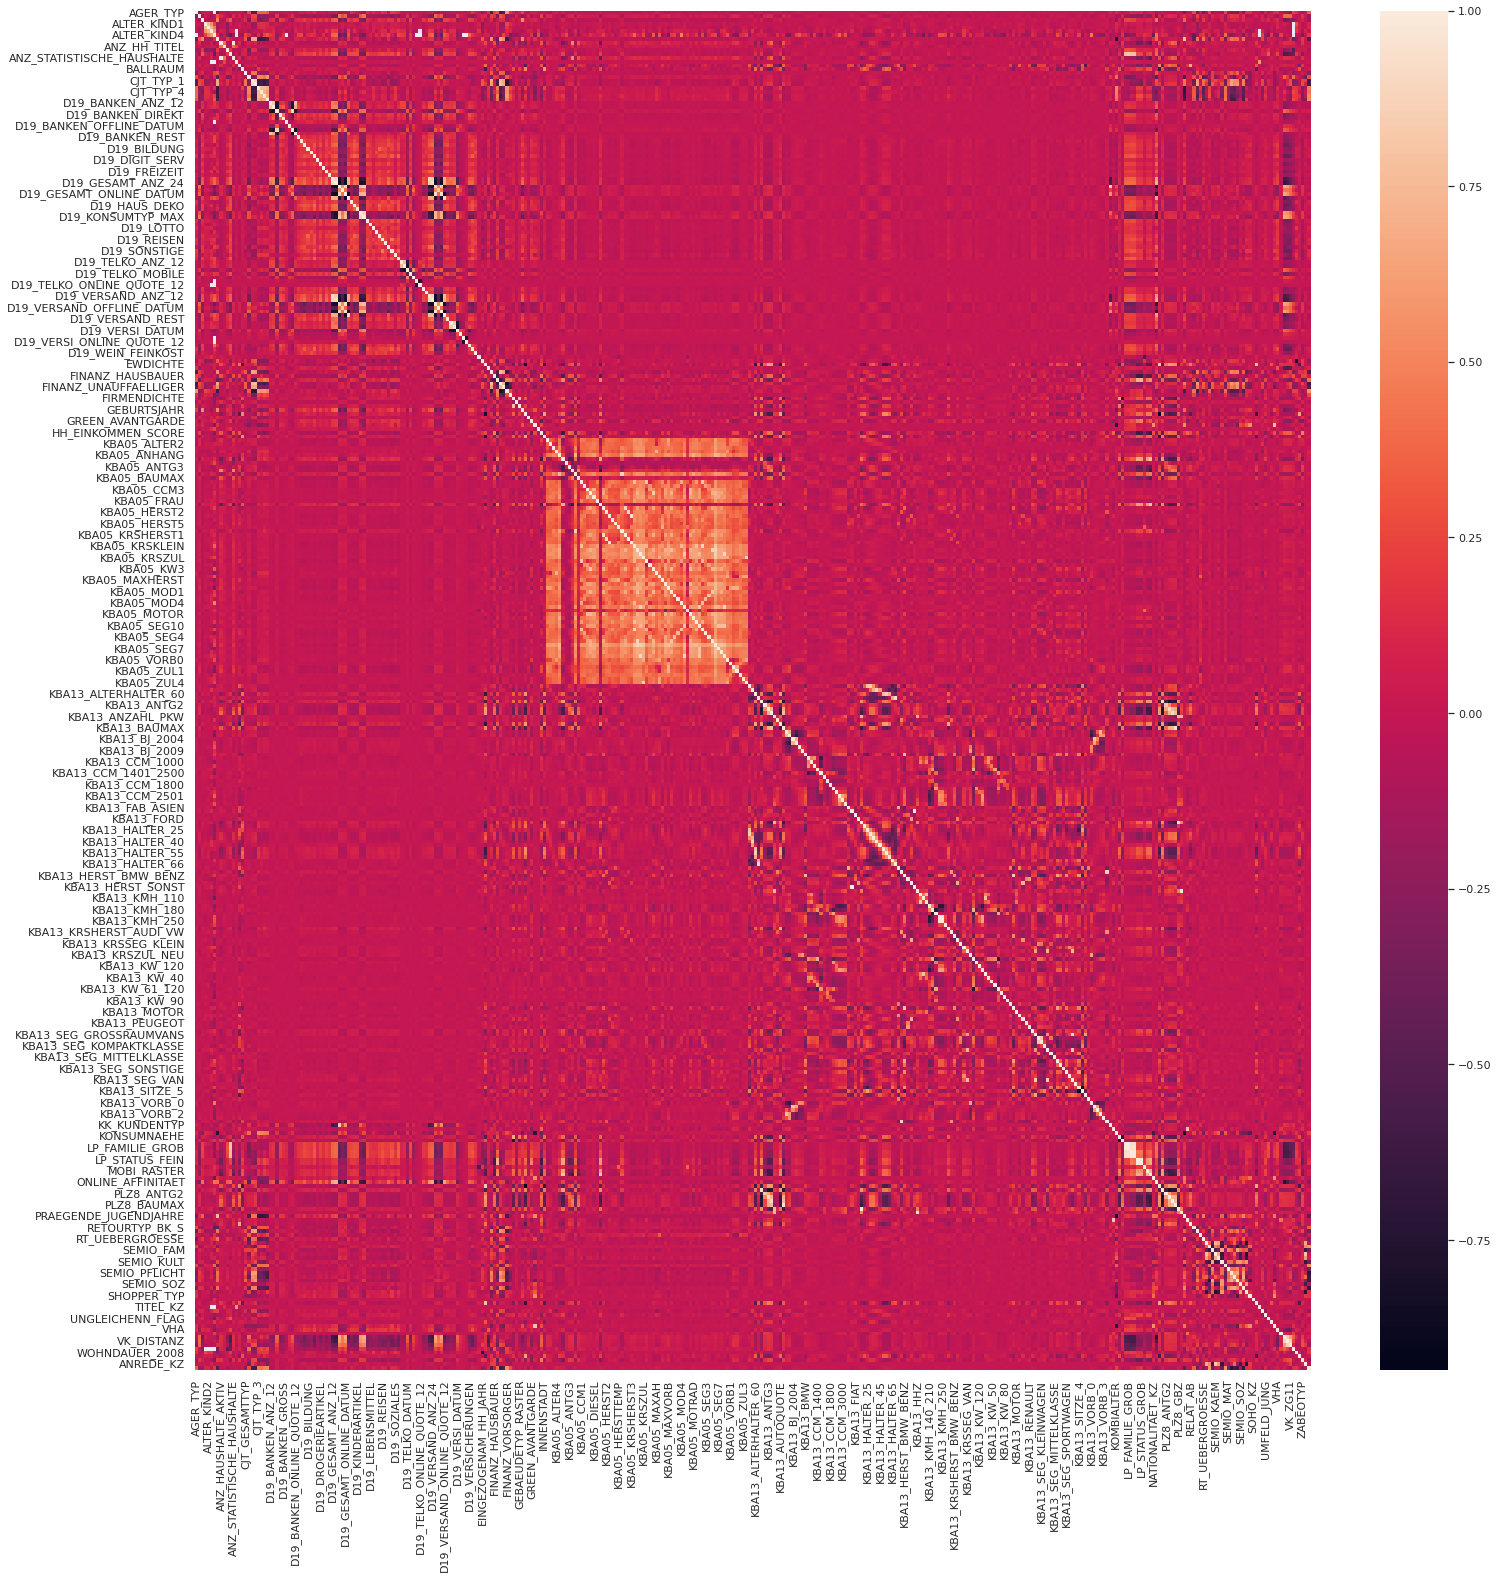

In [218]:
df_corr = df_azdias_cleaned.sample(30000).corr()
plt.figure(figsize=(25,25))
sns.heatmap(df_corr)

The heatmap shows a high correlation of KBA05* features, high correlation between some LP* features, between some D19* features,  between LP and some D19* features 

In [219]:
n = df_corr.shape[0]
df_ones = pd.DataFrame(np.ones([n,n]))
df_corr


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
AGER_TYP,1.000000,-0.278633,0.007179,0.035597,0.018737,0.002587,NaN,-0.387740,-0.026530,0.001580,-0.128413,0.012978,-0.021037,0.009724,0.003304,0.007830,-0.236758,0.261856,-0.502223,-0.498850,0.386142,0.363936,0.378025,0.322960,-0.015641,...,-0.269306,-0.329191,0.017779,-0.272613,0.140850,0.158021,0.004720,-0.001408,0.004927,-0.206707,0.087188,-0.059357,-0.016408,0.132660,0.146017,-0.012177,-0.047485,-0.184493,-0.286909,0.221214,0.142637,-0.017552,-0.133169,-0.018710,0.347541
AKT_DAT_KL,-0.278633,1.000000,-0.176281,0.036635,-0.052529,-0.143479,-0.027529,0.306397,0.125248,0.029368,-0.087706,-0.144758,0.125654,-0.019286,0.083497,-0.049894,0.057760,0.005273,0.248799,0.279311,-0.266387,-0.135341,-0.246633,-0.186438,-0.110873,...,0.174622,0.190428,0.022832,0.167979,-0.099959,-0.075959,0.000601,0.080522,-0.011332,0.080967,-0.125875,0.042272,0.042975,-0.031323,-0.180577,0.034220,0.382643,0.409603,0.378664,0.028878,-0.037008,-0.038806,0.174538,0.039918,-0.201592
ALTER_HH,0.007179,-0.176281,1.000000,-0.087885,-0.078842,-0.022468,-0.042530,0.523824,-0.079679,-0.044844,0.178099,0.331359,-0.084737,-0.006206,-0.056640,0.028424,0.132373,-0.300618,0.220108,0.187231,-0.236213,-0.305823,-0.217375,-0.202662,0.130298,...,0.114121,0.080371,0.023930,0.135074,0.018332,0.025509,0.008234,-0.051569,-0.014821,0.100448,0.035527,0.114963,-0.024769,0.063400,0.126626,-0.031795,-0.399501,-0.319952,-0.201015,-0.248292,-0.060931,0.024949,0.090507,-0.009862,-0.153867
ALTER_KIND1,0.035597,0.036635,-0.087885,1.000000,0.759311,0.562603,0.243255,-0.127019,-0.061210,0.005434,-0.276443,0.067863,-0.060124,0.014527,0.043483,0.002672,-0.089725,0.030016,-0.205890,-0.208870,0.143952,0.161227,0.144659,0.112282,-0.023556,...,-0.045463,-0.082158,-0.000274,-0.077567,0.020603,0.002643,-0.043321,-0.034869,0.001366,-0.039279,-0.009898,-0.044752,-0.002210,-0.008105,0.088440,0.010251,0.063409,-0.002925,-0.082371,NaN,0.262162,0.065900,-0.074991,-0.003401,0.096369
ALTER_KIND2,0.018737,-0.052529,-0.078842,0.759311,1.000000,0.709239,0.460543,-0.121055,-0.034365,0.009874,-0.196260,-0.016086,-0.026132,-0.018888,0.035534,0.004715,-0.023565,-0.001934,-0.149227,-0.149494,0.121040,0.138815,0.141937,0.079769,0.070202,...,-0.057532,-0.048144,0.021712,-0.070657,0.055640,-0.015118,-0.038840,-0.018295,0.001090,-0.059839,-0.029639,-0.051270,0.030370,-0.065255,0.109969,0.011921,0.001204,-0.028721,-0.053873,NaN,0.164452,0.044228,-0.012241,-0.026311,0.107660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,0.142637,-0.037008,-0.060931,0.262162,0.164452,0.182632,-0.030588,-0.256332,-0.051616,-0.002840,0.012190,0.192737,-0.040728,0.019527,-0.029693,0.043533,-0.073565,0.088566,-0.217027,-0.242558,0.183496,0.202766,0.201249,0.183366,-0.047886,...,-0.134640,-0.135022,-0.007720,-0.146648,0.041917,0.019970,0.011539,-0.049500,0.006701,-0.050620,0.079947,-0.013615,-0.026658,0.005850,0.121829,-0.029669,0.117397,-0.000689,-0.126668,-0.023107,1.000000,0.037782,-0.126944,-0.013542,0.172509
WOHNLAGE,-0.017552,-0.038806,0.024949,0.065900,0.044228,0.048030,-0.074272,0.009862,-0.089083,-0.036766,0.036450,0.065933,-0.086180,-0.004062,-0.292661,0.306097,-0.058624,-0.001362,-0.032827,-0.085032,0.083916,-0.005542,0.143982,0.050033,0.005358,...,-0.010556,-0.01300

### find feature with greatest correlation

I will no search for feature with very high correlation (>0.925). This feature will be removed.

In [220]:
n = df_corr.shape[0]
df_ones = np.zeros((n,n))
np.fill_diagonal(df_ones, 1)
df_ones = pd.DataFrame(df_ones, index=df_corr.index, columns=df_corr.columns)

In [221]:
df_high_corr_cols = df_corr.columns[(abs(df_corr - df_ones) > 0.9).any()]
print(len(df_high_corr_cols))
df_corr.loc[df_high_corr_cols[:10],df_high_corr_cols]

44


,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,GEMEINDETYP,KBA05_HERST2,KBA05_HERST3,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSVAN,KBA05_MOD8,KBA05_SEG9,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,KBA13_FAB_SONSTIGE,KBA13_GBZ,KBA13_HALTER_66,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_211,KBA13_KMH_250,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ
ANZ_HAUSHALTE_AKTIV,1.000000,0.982855,-0.107297,-0.116644,0.113779,-0.076463,-0.100777,-0.111669,0.117688,0.109209,-0.072433,-0.249958,0.048021,0.085015,0.073696,0.112108,0.112704,0.040019,0.056065,0.074233,-0.293081,0.248895,0.376926,0.326054,0.048961,-0.281363,0.066628,0.048961,0.092106,-0.022383,-0.023011,-0.126110,-0.130119,-0.200618,-0.176928,-0.362949,-0.349888,0.280254,-0.297092,0.250327,0.373025,0.329115,-0.283045,0.084158
ANZ_STATISTISCHE_HAUSHALTE,0.982855,1.000000,-0.108538,-0.118262,0.116169,-0.078744,-0.101607,-0.113135,0.118997,0.111143,-0.074345,-0.238802,0.064571,0.096563,0.090087,0.122395,0.133256,0.058945,0.075249,0.071098,-0.283527,0.241328,0.365760,0.313454,0.049251,-0.272421,0.064682,0.049251,0.089402,-0.021211,-0.021839,-0.125158,-0.129916,-0.196279,-0.174166,-0.352157,-0.338959,0.267546,-0.287663,0.242040,0.361650,0.316466,-0.274509,0.081818
D19_GESAMT_ANZ_12,-0.107297,-0.108538,1.000000,0.905589,-0.810313,0.724380,0.909126,0.857614,-0.799981,-0.786828,0.699713,0.090455,-0.016890,-0.038728,-0.022725,-0.039841,-0.031809,0.008096,-0.006038,-0.024623,0.130619,-0.134459,-0.117903,-0.113068,-0.022037,0.080213,-0.024595,-0.022037,-0.035749,0.001089,0.000490,0.346531,0.360063,0.365725,0.359826,0.190013,0.195417,-0.090222,0.135785,-0.136163,-0.121559,-0.110039,0.078756,-0.029307
D19_GESAMT_ANZ_24,-0.116644,-0.118262,0.905589,1.000000,-0.845934,0.697854,0.831958,0.922621,-0.834752,-0.818645,0.676120,0.101985,-0.020186,-0.045288,-0.027746,-0.047427,-0.038365,0.006808,-0.009172,-0.026853,0.142251,-0.146252,-0.129398,-0.125723,-0.027127,0.090412,-0.026324,-0.027127,-0.036663,0.001123,0.002369,0.373550,0.390941,0.397486,0.391226,0.203628,0.211336,-0.100744,0.146991,-0.147572,-0.135661,-0.122918,0.089073,-0.031872
D19_GESAMT_ONLINE_DATUM,0.113779,0.116169,-0.810313,-0.845934,1.000000,-0.869267,-0.780703,-0.819684,0.914610,0.944233,-0.820815,-0.084938,0.017859,0.051358,0.020389,0.054319,0.039632,-0.003789,0.011027,0.027227,-0.126166,0.129003,0.111030,0.107490,0.024125,-0.084029,0.026714,0.024125,0.025940,-0.001611,-0.003092,-0.347241,-0.368128,-0.374691,-0.367907,-0.192995,-0.203065,0.086883,-0.132328,0.130312,0.114999,0.105644,-0.081844,0.021639
D19_GESAMT_ONLINE_QUOTE_12,-0.076463,-0.078744,0.724380,0.697854,-0.869267,1.000000,0.695500,0.680025,-0.763466,-0.809330,0.919217,0.044465,0.004195,-0.020333,0.004150,-0.019940,-0.016784,0.017007,0.004611,-0.034113,0.078961,-0.085229,-0.065337,-0.061369,-0.017913,0.056348,-0.033917,-0.017913,-0.005971,0.001301,0.002771,0.223685,0.236565,0.228621,0.224237,0.117825,0.110738,-0.048530,0.085271,-0.084157,-0.067205,-0.059074,0.052861,-0.003966
D19_VERSAND_ANZ_12,-0.100777,-0.101607,0.909126,0.831958,-0.780703,0.695500,1.000000,0.905446,-0.828774,-0.817496,0.752294,0.076432,-0.011743,-0.038806,-0.017336,-0.039882,-0.028878,0.007808,-0.005357,-0.019767,0.120795,-0.122074,-0.110008,-0.103121,-0.020682,0.077181,-0.020504,-0.020682,-0.029027,0.004576,0.006406,0.316154,0.328634,0.334060,0.328135,0.179390,0.183974,-0.076435,0.127248,-0.123224,-0.111868,-0.099006,0.076208,-0.023156
D19_VERSAND_ANZ_24,-0.111669,-0.113135,0.857614,0.922621,-0.819684,0.680025,0.905446,1.000000,-0.864509,-0.851115,0.721216,0.088249,-0.012397,-0.044243,-0.019447,-0.046284,-0.033858,0.009129,-0.005731,-0.021116,0.134076,-0.1334

In [222]:
high_corr_dict = {}
candidate_to_drop = set()
corr_threshold = 0.9
for col in df_corr.loc[df_high_corr_cols[:30],df_high_corr_cols]:
    col_correaltions = df_corr[col].sort_values(ascending=False)
    tmp_list = []
    
    for corr_col in col_correaltions.index:
        if corr_col != col:
            if (col_correaltions[corr_col] >= corr_threshold) and not corr_col in high_corr_dict:
                candidate_to_drop.add(corr_col)
                tmp_list.append({corr_col : col_correaltions[corr_col]})
            else:
                break
    
    if tmp_list:
        high_corr_dict[col] = tmp_list
                
candidate_to_drop
    

{'ANZ_STATISTISCHE_HAUSHALTE',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_SEG9',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ'}

In [223]:
high_corr_dict

{'ANZ_HAUSHALTE_AKTIV': [{'ANZ_STATISTISCHE_HAUSHALTE': 0.9828545111479542}],
 'D19_GESAMT_ANZ_12': [{'D19_VERSAND_ANZ_12': 0.9091255370921416},
  {'D19_GESAMT_ANZ_24': 0.9055889669648077}],
 'D19_GESAMT_ANZ_24': [{'D19_VERSAND_ANZ_24': 0.9226208364696762}],
 'D19_GESAMT_ONLINE_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9442332998133063},
  {'D19_VERSAND_DATUM': 0.9146101521150092}],
 'D19_GESAMT_ONLINE_QUOTE_12': [{'D19_VERSAND_ONLINE_QUOTE_12': 0.9192169433147243}],
 'D19_VERSAND_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9598717667187688}],
 'KBA05_HERST2': [{'KBA05_KRSHERST2': 0.9035899310608735}],
 'KBA05_HERST3': [{'KBA05_KRSHERST3': 0.9256786802070253}],
 'KBA05_KRSVAN': [{'KBA05_SEG9': 0.9044347688379291}],
 'KBA05_MOD8': [{'KBA05_SEG9': 0.9045445876811398}],
 'KBA13_ALTERHALTER_61': [{'KBA13_HALTER_66': 0.9262939308332045}],
 'KBA13_ANTG1': [{'PLZ8_ANTG1': 0.9176961776084096}],
 'KBA13_ANTG3': [{'PLZ8_ANTG3': 0.9098856308418932}],
 'KBA13_ANTG4': [{'PLZ8_ANTG4': 0.9028501426379906}]

<AxesSubplot:>

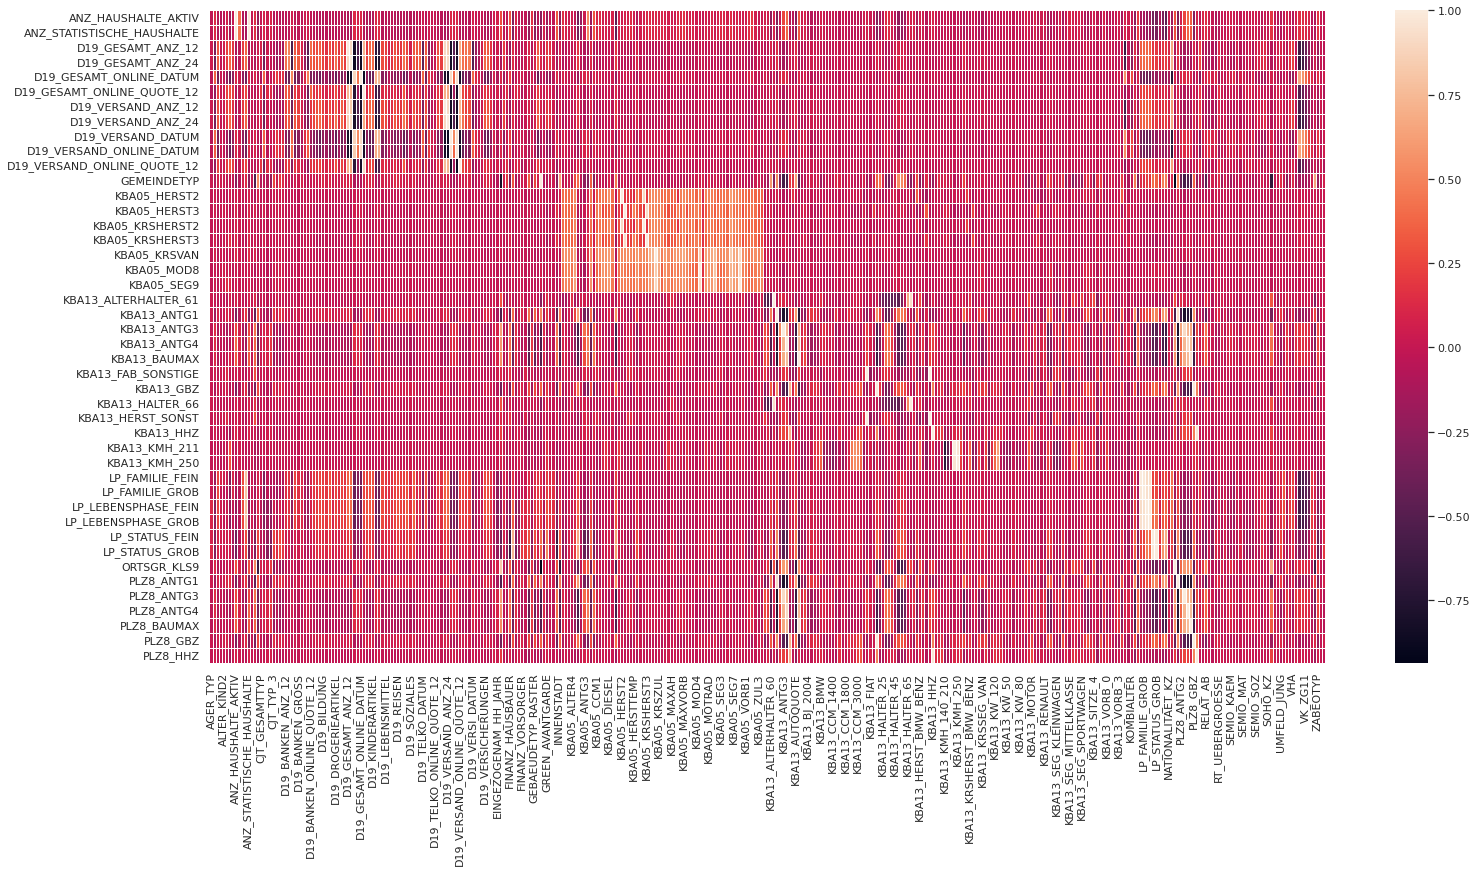

In [224]:
plt.figure(figsize=(25,12))
sns.heatmap(df_corr.loc[df_high_corr_cols,:], linewidths=0.8)


#### Analyse Variabls Lebensphase 

The following attributes seems to be very similar

* LP_LEBENSPHASE_GROB lifestage rough
* LP_LEBENSPHASE_FEIN lifestage fine
* LP_STATUS_FEIN
* LP_STATUS_GROB
* LP_FAMILIE_GROB
* LP_FAMILIE_FEIN

Therefore we make a short correlation check

In [238]:
cols = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_GROB', 'LP_STATUS_FEIN',  'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'CAMEO_INTL_2015','CAMEO_DEUG_2015','W_KEIT_KIND_HH', 'CJT_TYP_1','CJT_TYP_2']
df_azdias_cleaned[cols].corr()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_GROB,LP_STATUS_FEIN,LP_FAMILIE_GROB,LP_FAMILIE_FEIN,W_KEIT_KIND_HH,CJT_TYP_1,CJT_TYP_2
LP_LEBENSPHASE_FEIN,1.000000,0.989961,0.463909,0.443415,0.941647,0.917662,-0.374025,-0.190931,-0.250607
LP_LEBENSPHASE_GROB,0.989961,1.000000,0.407881,0.390511,0.957661,0.942819,-0.378359,-0.154193,-0.210626
LP_STATUS_GROB,0.463909,0.407881,1.000000,0.982411,0.245960,0.241076,-0.104775,-0.259928,-0.336123
LP_STATUS_FEIN,0.443415,0.390511,0.982411,1.000000,0.234589,0.236180,-0.125627,-0.195305,-0.276832
LP_FAMILIE_GROB,0.941647,0.957661,0.245960,0.234589,1.000000,0.984100,-0.434638,-0.036257,-0.083982
LP_FAMILIE_FEIN,0.917662,0.942819,0.241076,0.236180,0.984100,1.000000,-0.421173,-0.015491,-0.061680
W_KEIT_KIND_HH,-0.374025,-0.378359,-0.104775,-0.125627,-0.434638,-0.421173,1.000000,-0.326131,-0.276431
CJT_TYP_1,-0.190931,-0.154193,-0.259928,-0.195305,-0.036257,-0.015491,-0.326131,1.000000,0.897413
CJT_TYP_2,-0.250607,-0.210626,-0.336123,-0.276832,-0.083982,-0.061680,-0.276431,0.897413,1.000000


<AxesSubplot:>

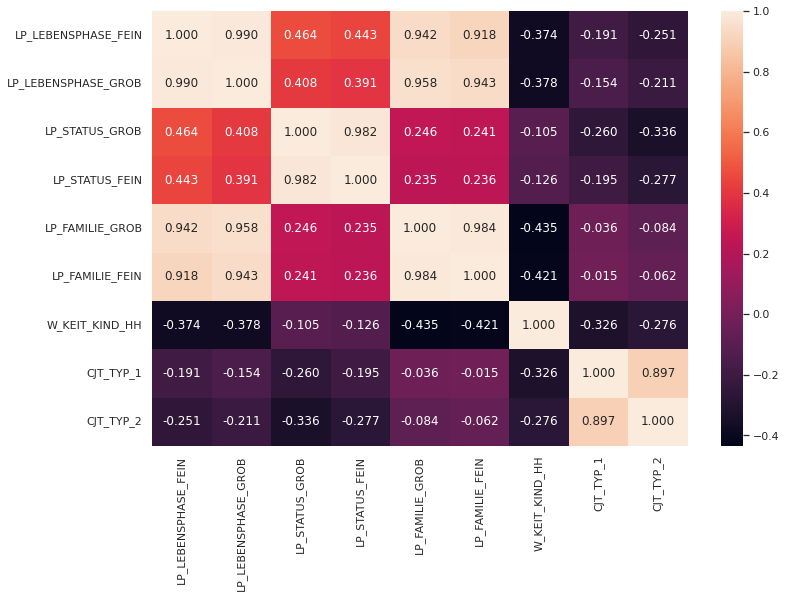

In [239]:
plt.figure(figsize=(12,8))
sns.heatmap(df_azdias_cleaned[cols].corr(), annot=True, fmt="3.3f")

**Result**

* LP_STATUS_FEIN and LP_STATUS_GROB are almost the same. As LP_STATUS_FEIN contains the more detailed level of information we keep this and drop LP_STATUS_GROB
* 

### High Anti correlated features

In [240]:
high_corr_dict = {}
candidate_to_drop = set()
corr_threshold = 0.9
for col in df_corr.loc[df_high_corr_cols[:30],df_high_corr_cols]:
    col_correaltions = df_corr[col].sort_values(ascending=True)
    tmp_list = []
    
    for corr_col in col_correaltions.index:
        if corr_col != col:
            if (abs(col_correaltions[corr_col]) >= corr_threshold) and not corr_col in high_corr_dict:
                candidate_to_drop.add(corr_col)
                tmp_list.append({corr_col : col_correaltions[corr_col]})
            else:
                break
    
    if tmp_list:
        high_corr_dict[col] = tmp_list
                
candidate_to_drop

{'ORTSGR_KLS9'}

In [241]:
high_corr_dict

{'GEMEINDETYP': [{'ORTSGR_KLS9': -0.9345061815239755}]}

### Run the cleaning process

In [69]:
dfCleaner = etlp.PreDataCleaner(df_metadata)

df_azdias_cleaned = dfCleaner.transform(df_azdias_cleaned,drop_cols=True)
df_azdias_cleaned.shape

fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 373
fixed column CAMEO_INTL_2015 - records fixed: 373
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']
replace unkown values by NaNs: 
 233 of 233	Processed columnscolumns	Processed columns	Processed columns	Processed columns	Processed columns	Processed columns	Processed columns	Processed columns	Processed columns
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}
dropping columns: ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'D19_VERSAND_ANZ_24', 'LP_LEBENSPHASE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'D19_VERSAND_ONLINE_DATUM', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_DATUM', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_SEG9', 'KBA13_KMH_211', 'PL

(891221, 323)

### Check distribution of Missing values and Correclations again

<AxesSubplot:>

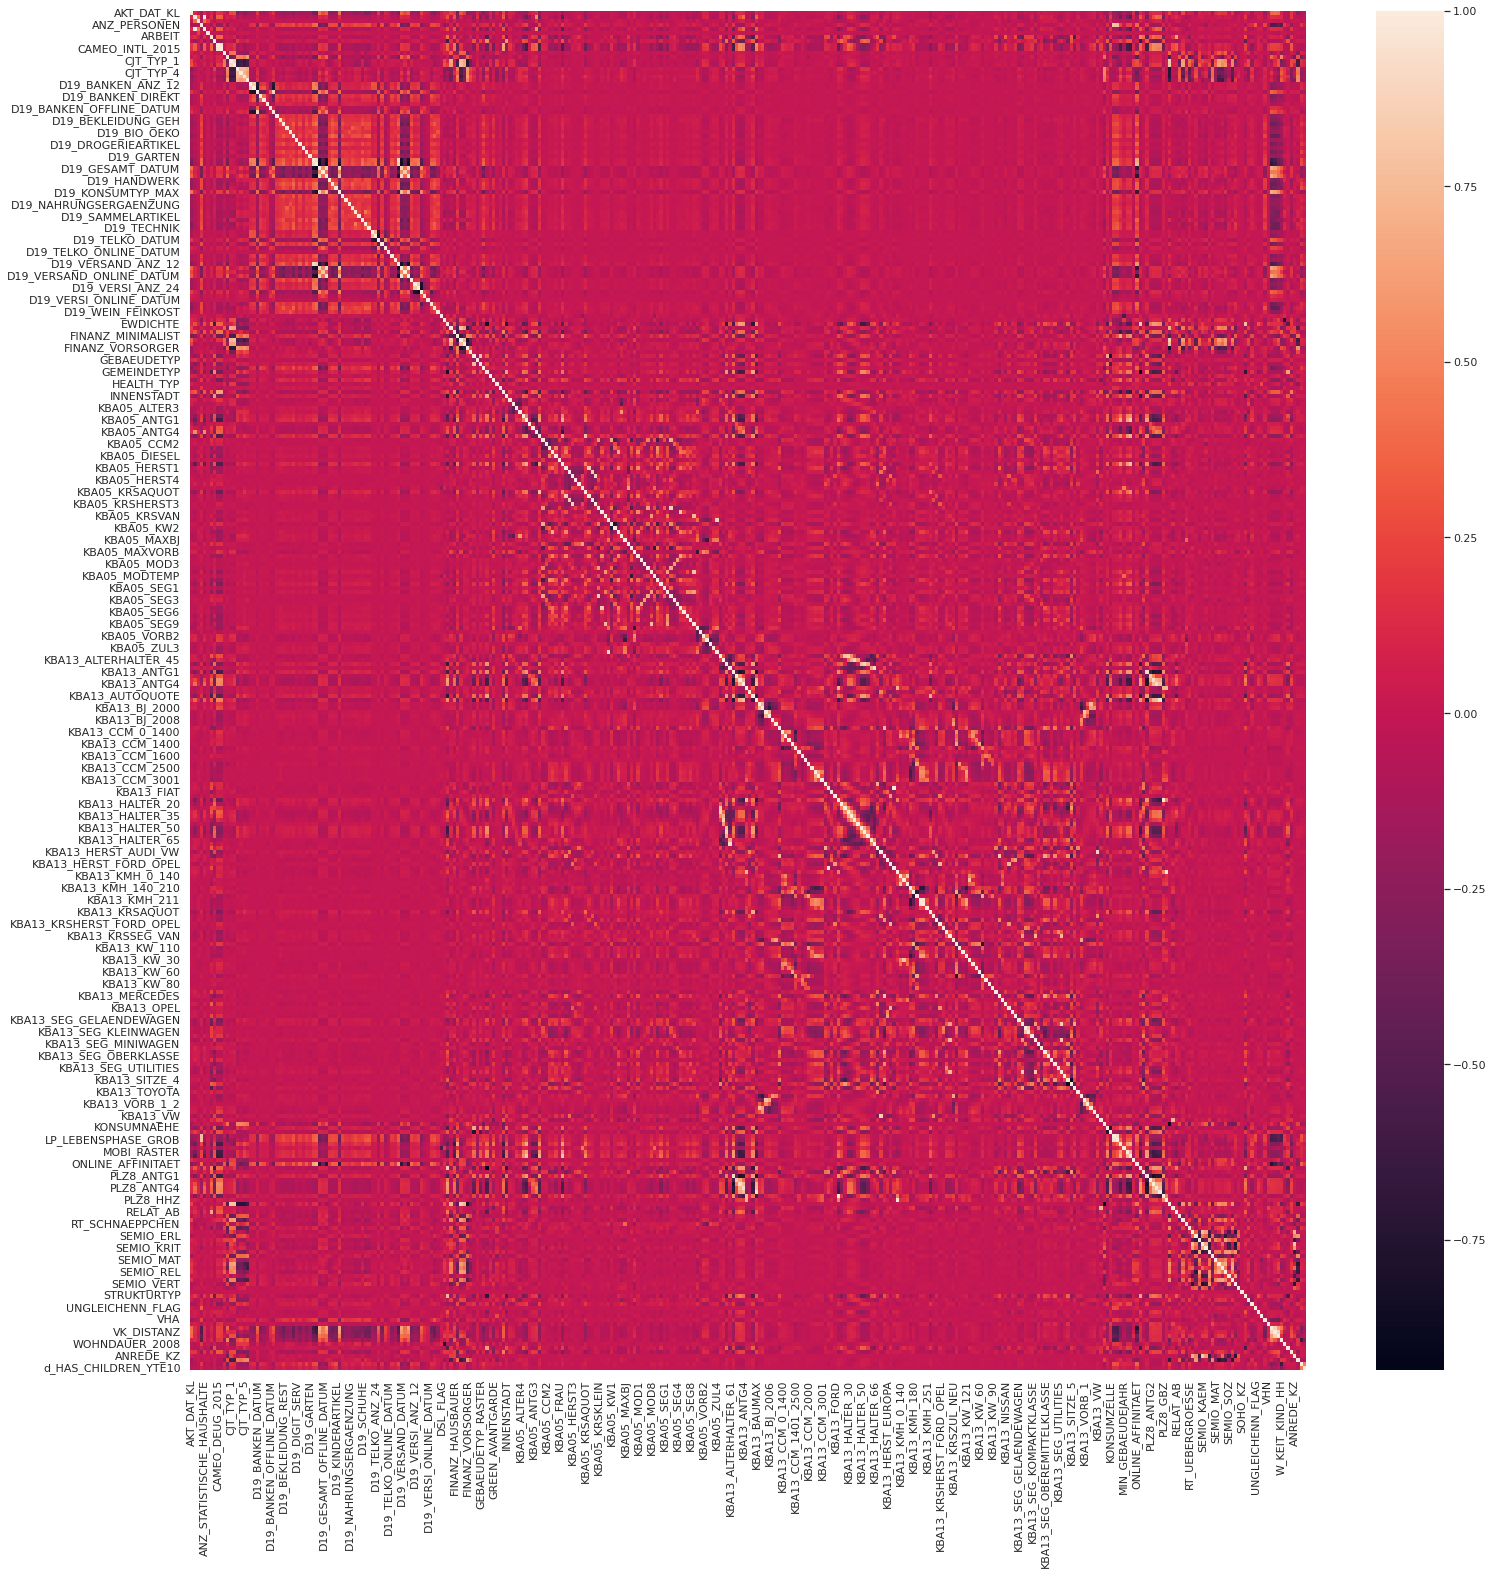

In [243]:
df_corr = df_azdias_cleaned.sample(30000).corr()
plt.figure(figsize=(25,25))
sns.heatmap(df_corr)

<AxesSubplot:>

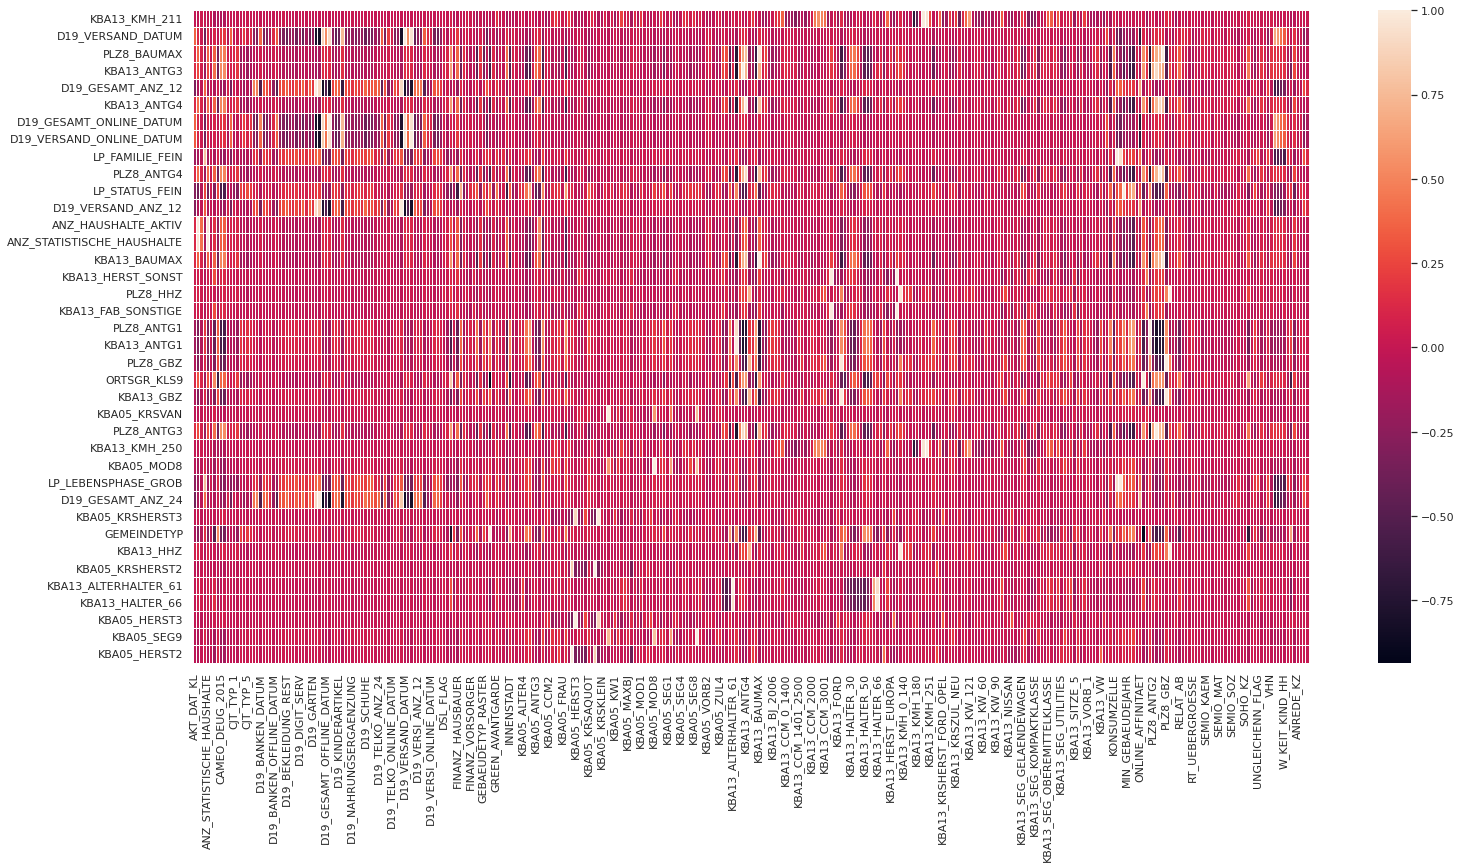

In [246]:
col_set = set(df_high_corr_cols).intersection(df_corr.columns)
plt.figure(figsize=(25,12))
sns.heatmap(df_corr.loc[col_set,:], linewidths=0.8)

<AxesSubplot:>

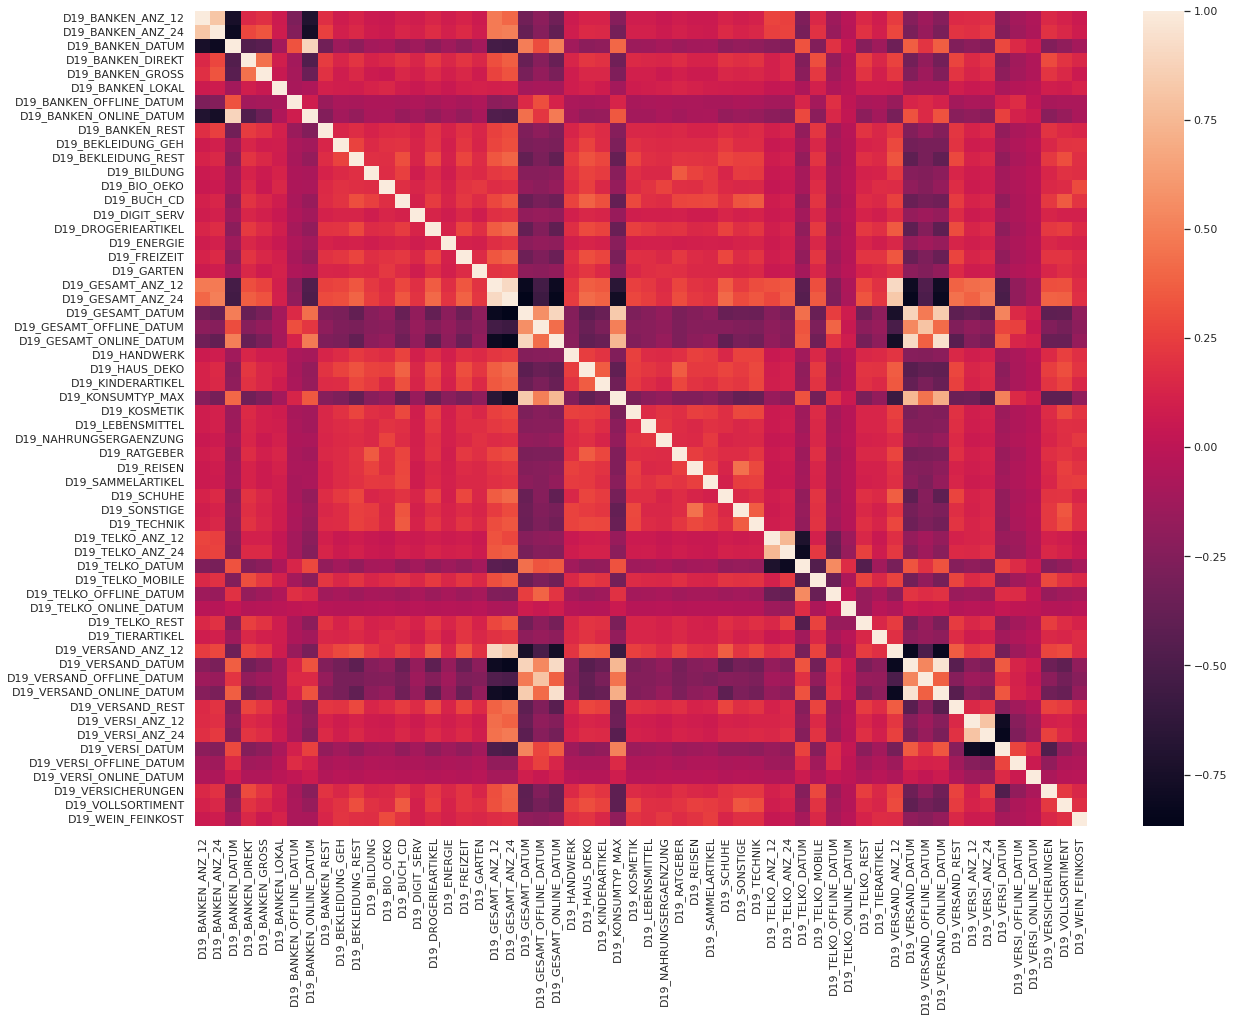

In [262]:
df_d19_corr = df_azdias_cleaned.filter(regex='D19.*',axis='columns').corr()
plt.figure(figsize=(20,15))
sns.heatmap(df_d19_corr)

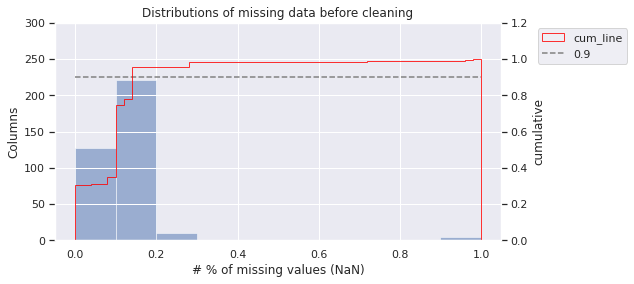

In [247]:
# Assess missing data in columns
plot.Plot.print_null_dist(df_azdias, 'dist_of_missingdata_after_transformation.jpg')


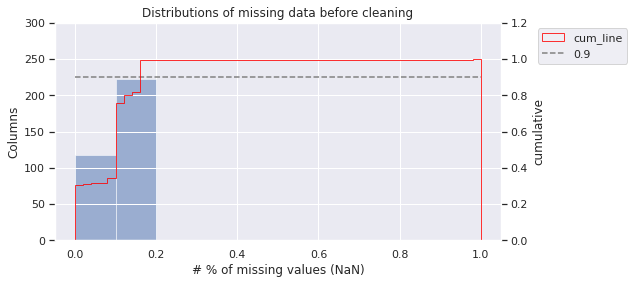

In [254]:
plot.Plot.print_null_dist(df_azdias_cleaned, 'dist_of_missingdata_after_transformation.jpg')

In [255]:
num_of_records = df_azdias_cleaned.shape[0]
s_missing_data = df_azdias_cleaned.isnull().sum(axis=0)
s_missing_data_pct = df_azdias_cleaned.isnull().sum(axis=0) / num_of_records 

df_missing_data = pd.DataFrame({'abs':s_missing_data,'pct':s_missing_data_pct})
df_missing_data.sort_values(by='pct', ascending=False)[:20]

,abs,pct
REGIOTYP,158064,0.177357
KKK,158064,0.177357
KBA05_AUTOQUOT,148115,0.166193
KBA05_HERST2,148110,0.166188
KBA05_HERST5,148110,0.166188
KBA05_HERST3,148110,0.166188
KBA05_SEG6,148110,0.166188
KBA05_HERST1,148110,0.166188
KBA05_FRAU,148110,0.166188
KBA05_DIESEL,148110,0.166188


**Results**: 

* there is a significant increase of columns with no missing data  
This is because of the transformation of categorical features to one-hot encoded columns. Therfore the number of columns increased with no missing values.
* the other changes are becuse we replaced "unknown" values by np.NaN

## Save cleaned Datasets
Note: using feather requires to reset the index

In [70]:
df_azdias_cleaned.reset_index().to_feather('df_azdias_cleaned')

# Feature Engineering
Many records have ANZ_KINDER (number of children) = 0. 
For theses records the age of children columns (ALTER_KIND(N)) are always NaN. For records with a positive number 
of children the ALTER_KIND columns contains the age of children. We will replace these columns by summerize the
 them to two columns that will indicate the number of children younger than 10 and older or equal than 10.

In [265]:
df  = df_azdias_cleaned
cols_to_investigate = ['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','ANZ_KINDER']
df_kinder = df[cols_to_investigate]


KeyError: "None of [Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',\n       'ANZ_KINDER'],\n      dtype='object')] are in the [columns]"

In [ ]:
#df_kinder = df_azdias_cleaned.filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

figure, ax_list = plt.subplots(1,5,figsize=(24,5))

for i, col in enumerate(cols_to_investigate):
    df_kinder[col].value_counts().plot(kind='bar',ax=ax_list[i], title=col)

**Results**: The majority has no children. The dataset is quite imbalanced. Even the age of children is havily imbalanced. As you can see in chart `ALTER_KIND1` the distribution of ages has much higher values for >5 than for <=5

Based on the observations above I will build a new feature `d_has_children` and `d_has_children_yte10` to indicate that person has children younger or equal than 10.

In [147]:
df_azdias_cleaned.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,...,D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Run Feature Engineering Process

In [148]:
import python.etl.processor as etlp

featureBuilder = etlp.FeatureBuilder()
df_azdias_cleaned = featureBuilder.transform(df_azdias_cleaned)


In [149]:
df_azdias_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 389 entries, AGER_TYP to d_HAS_CHILDREN_YTE10
dtypes: float64(292), int64(97)
memory usage: 2.6 GB


## Save results
saving the results here will help to continue development and testing the next steps

**Info**: [Best way to save pandas Dataframe](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d)


In [266]:
df_azdias_cleaned.reset_index().to_feather('df_azdias_cleaned_step2-feaEngineered')

## Loading DF
you can start here if you want to skip steps before

In [71]:
df_azdias_cleaned = pd.read_feather('df_azdias_cleaned')

# set the index as feather did store the index as column
df_azdias_cleaned.set_index('LNR', inplace=True)
df_azdias_cleaned.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,0,0
910220,9.0,11.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,1.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,0,0
910225,9.0,10.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,2.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,0,0
910226,1.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,3.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,0,0
910241,1.0,3.0,0.0,4.0,0.0,4.0,2.0,6.0,5.0,3.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,0,0


# Part 1: Customer Segmentation Report
---

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Cluster algorithms
For clustering there is number of popular algorithms. For the algorthim selection I focused on the ones that scikit-learn provides and on the article [clustering algorithms with python](https://machinelearningmastery.com/clustering-algorithms-with-python/) or [How to Combine PCA and K-means CLustering](https://365datascience.com/tutorials/python-tutorials/pca-k-means/).

According to the references the most popular algorithms are
* Affinity Propagation
* Agglomerative Clustering
* BIRCH
* DBSCAN
* **K-Means**
* **Mini-Batch K-Means**
* Mean Shift
* OPTICS
* Spectral Clustering
* Mixture of Gaussians

the bold one are the one(s) I used 

## Feature Reduction and Selection

The dimension of the dataset is quite high (442 features) so that it is worth to consider a reduction of the dimensionality which will increase the performance and in many cases the accuracy of algorithm. In particular the popular K-means which I will use will profit from it.

See e.g. [PCA with k-means](https://365datascience.com/tutorials/python-tutorials/pca-k-means/)

## Approach 

1. **PCA - Principal Component Analysis**  
This algorithms is also provided by scikit-learn. It will transform the given space of features to new space with basis vectors that are linear combinations of the given features so that the new vectors point in direction of the maximum variance. For more information how to execute and interpret the values see [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
    1. **Impute missing data**
    1. **Standardize data**
    1. **Execute PCA**

1. **K-means** 


For the complete process I will use a sklearn pipeline to chain the steps

In [1]:
%load_ext autoreload
%autoreload 2

## Prepare the pipeline steps

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_theme()

In [3]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from python.etl.plot import Plot


In [4]:
from  python.model.pca import PCAProcessor

### Load Data
loads pre-processed data from a savepoint

In [5]:
import os

# this is NOT needed if you start from the beginning
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    prefix = 's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'
	
#df_azdias = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
df_customers = pd.read_csv(f'{prefix}/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# some columns of the metadata ends on _RZ whereas the datasets have the same columns whcih do not end on _RZ
# therefore we replace this
df_metadata['Attribute'] = df_metadata['Attribute'].str.replace('_RZ','')


In [7]:
df_population_cleaned = pd.read_feather('df_azdias_cleaned')

# set the index as feather-format did store the index as column
df_population_cleaned.set_index('LNR', inplace=True)
df_population_cleaned.head()


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,0,0
910220,9.0,11.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,1.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,0,0
910225,9.0,10.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,2.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,0,0
910226,1.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,3.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,0,0
910241,1.0,3.0,0.0,4.0,0.0,4.0,2.0,6.0,5.0,3.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,0,0


In [8]:
df_population_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 323 entries, AKT_DAT_KL to d_HAS_CHILDREN_YTE10
dtypes: float64(264), int64(59)
memory usage: 2.2 GB


### Imputation

fill missing data with data. This is done by the PcaAnalyser class.

### Standardization

An important preprocessing step for PCA is stanardization (scaling) of the features. See [Importance of Feature Scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) for mor information.

This step is also executed by the PCA analyser class.

###  PCA

References: 
* [Explaining K-Means clustering](https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6)

execute the principal component analysis. One of the main questions is how many principal components we want to keep, means on which dimension do we want to reduces the original dataset.

I now execute the following steps
1. PCA standardizing, fitting and transformation in one step on the population data set.
1. display the explained varaince in order to determine the number of components to keep
1. run PCA standardizing, fitting and transformation on reduced number of components
1. apply PCA on customer dataset

In [9]:
pca_processor = PCAProcessor(df_population_cleaned, df_metadata)
pca_processor.fit_transform()

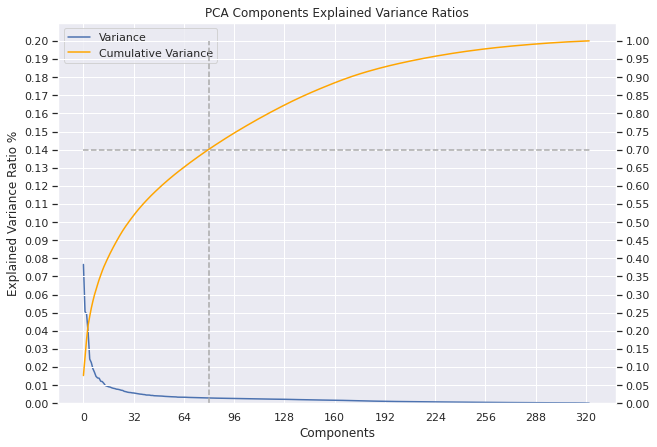

In [10]:
p_explained_variance = 0.7
pca_processor.plot(p_explained_variance)

In [11]:
n_reduced_components = pca_processor.get_components_for_variance(p_explained_variance)
n_reduced_components

80

In [12]:
print(f'{n_reduced_components  / pca_processor.X_train_transformed.shape[1]:5.4f}% components to get {p_explained_variance}% of variance')

0.2477% components to get 0.7% of variance


**Results**: The plot shows that 70% of the variance is explained by 80 components (250% of the components).
I map the dataset to these 80 components for further analysis

#### PCA - show components

Show first and last n_show weights of components 1 - 3

In [13]:
n_show = 7

Component I

In [14]:
pca_processor.get_component_features(0)[:n_show]

Explained Variance in % for cmponent: 0: 0.0766


,Attribute,Variance,Description
0,LP_STATUS_FEIN,0.141667,social status fine
1,MOBI_REGIO,0.141030,moving patterns
2,KBA05_ANTG1,0.131357,number of 1-2 family houses in the cell
3,KBA05_AUTOQUOT,0.125310,share of cars per household
4,KBA13_AUTOQUOTE,0.124132,share of cars per household within the PLZ8
5,KBA05_GBZ,0.124043,number of buildings in the microcell
6,FINANZ_MINIMALIST,0.122537,financial typology: low financial interest


In [15]:
pca_processor.get_component_features(0)[-n_show:]

Explained Variance in % for cmponent: 0: 0.0766


,Attribute,Variance,Description
303,FINANZ_HAUSBAUER,-0.111914,financial typology: main focus is the own house
304,ORTSGR_KLS9,-0.113190,size of the community
305,ORTSGR_KLS9,-0.113190,'- classified number of inhabitants
306,HH_EINKOMMEN_SCORE,-0.115185,estimated household net income
307,EWDICHTE,-0.116008,density of inhabitants per square kilometer
308,CAMEO_DEUG_2015,-0.131743,CAMEO classification 2015 - Uppergroup
309,PLZ8_ANTG4,-0.131887,number of >10 family houses in the PLZ8


Component II

In [16]:
pca_processor.get_component_features(1)[:n_show]

Explained Variance in % for cmponent: 1: 0.0506


,Attribute,Variance,Description
0,KBA13_HERST_BMW_BENZ,0.164526,share of BMW & Mercedes Benz within the PLZ8
1,KBA13_MERCEDES,0.142353,share of MERCEDES within the PLZ8
2,KBA13_SEG_OBEREMITTELKLASSE,0.138099,share of upper middle class cars and upper cla...
3,KBA13_BMW,0.135059,share of BMW within the PLZ8
4,KBA13_SEG_SPORTWAGEN,0.129444,share of sportscars within the PLZ8
5,KBA13_SITZE_4,0.128586,number of cars with less than 5 seats in the PLZ8
6,KBA13_KW_121,0.115397,share of cars with an engine power more than 1...


In [17]:
pca_processor.get_component_features(1)[-n_show:]

Explained Variance in % for cmponent: 1: 0.0506


,Attribute,Variance,Description
303,KBA13_KW_0_60,-0.106131,share of cars up to 60 KW engine power - PLZ8
304,KBA13_SEG_KOMPAKTKLASSE,-0.107068,share of lowe midclass cars (Ford Focus etc.) ...
305,KBA13_HALTER_25,-0.112913,share of car owners between 21 and 25 within t...
306,KBA13_KMH_180,-0.113760,share of cars with max speed between 110 km/h ...
307,KBA13_KMH_140_210,-0.116236,share of cars with max speed between 140 and 2...
308,KBA13_SEG_KLEINWAGEN,-0.120729,share of small and very small cars (Ford Fiest...
309,KBA13_SITZE_5,-0.135311,number of cars with 5 seats in the PLZ8


Component III


In [18]:
pca_processor.get_component_features(2)[:n_show]

Explained Variance in % for cmponent: 2: 0.0492


,Attribute,Variance,Description
0,PRAEGENDE_JUGENDJAHRE,0.167380,dominating movement in the person's youth (ava...
1,FINANZ_SPARER,0.152440,financial typology: money saver
2,ONLINE_AFFINITAET,0.149354,online affinity
3,SEMIO_TRADV,0.142964,affinity indicating in what way the person is ...
4,SEMIO_PFLICHT,0.135611,affinity indicating in what way the person is ...
5,SEMIO_RAT,0.126570,affinity indicating in what way the person is ...
6,FINANZ_UNAUFFAELLIGER,0.124369,financial typology: unremarkable


In [19]:
pca_processor.get_component_features(2)[-n_show:]

Explained Variance in % for cmponent: 2: 0.0492


,Attribute,Variance,Description
303,RETOURTYP_BK_S,-0.093420,return type
304,D19_GESAMT_DATUM,-0.103336,actuality of the last transaction with the com...
305,SEMIO_LUST,-0.106568,affinity indicating in what way the person is ...
306,FINANZ_MINIMALIST,-0.108020,financial typology: low financial interest
307,D19_GESAMT_ONLINE_DATUM,-0.109070,actuality of the last transaction with the com...
308,FINANZ_VORSORGER,-0.141697,financial typology: be prepared
309,ALTERSKATEGORIE_GROB,-0.141942,age classification through prename analysis


#### apply PCA on reduced number of dimensions

In [20]:
pca_reduced = PCAProcessor(df_population_cleaned, df_metadata, n_reduced_components, random_state=42)
pca_reduced.fit_transform()

df_population_pca = pca_reduced.X_train_transformed

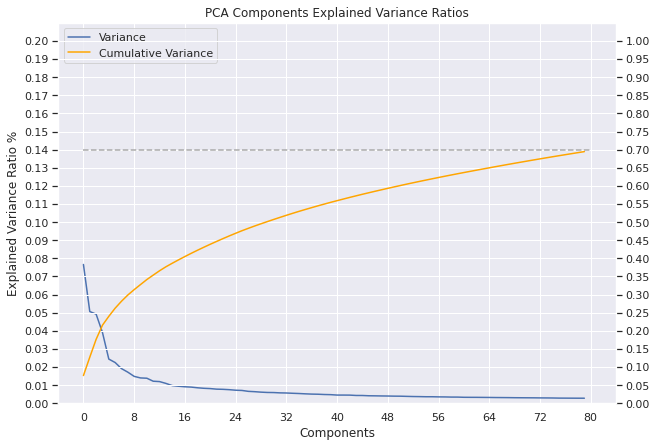

In [21]:
pca_reduced.plot(p_explained_variance)

### Customer Data Set

Now I load the customer data set and apply the PCA transformation with reduced number of components. The result is then used by KMeans for the customer segmentation report.

In [22]:
import python.etl.processor as etlp
df_customers_cleaned = df_customers.copy()
dfCleaner = etlp.PreDataCleaner(df_metadata)

df_customers_cleaned = dfCleaner.transform(df_customers_cleaned, drop_cols=True)
print(df_customers_cleaned.shape)



Dropping customer dataset cols: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
dropping columns: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 126
fixed column CAMEO_INTL_2015 - records fixed: 126
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']
replace unkown values by NaNs: 
 233 of 233	Processed columns	Processed columns	Processed columns	Processed columns
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}
dropping columns: ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'D19_VERSAND_ANZ_24', 'LP_LEBENSPHASE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'D19_VERSAND_ONLINE_DATUM', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_DATUM', 'KBA05_KR

In [23]:
df_customers_cleaned.reset_index().to_feather('df_customers_cleaned')

In [24]:
set(df_customers_cleaned.columns) - set(df_population_cleaned.columns)

set()

In [25]:
set(df_population_cleaned.columns) - set(df_customers_cleaned.columns)

set()

In [26]:
print(df_customers_cleaned.shape)
print(df_population_cleaned.shape)
print(df_customers.shape)

(191652, 323)
(891221, 323)
(191652, 368)


In [27]:
df_customers_cleaned.head()


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,1.0,0.0,2.0,0.0,1.0,3.0,1.0,5.0,4.0,...,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0,0,0
9628,9.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,NaN,9.0,NaN,3.0,1.0,4.0,0,0
143872,1.0,1.0,0.0,1.0,0.0,3.0,7.0,5.0,2.0,5.0,...,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0,0,0
143873,1.0,0.0,NaN,0.0,0.0,1.0,7.0,4.0,2.0,5.0,...,4.0,2.0,NaN,9.0,7.0,1.0,1.0,4.0,0,0
143874,1.0,7.0,0.0,4.0,0.0,3.0,3.0,7.0,6.0,4.0,...,5.0,4.0,2.0,9.0,3.0,1.0,1.0,3.0,0,0


In [28]:
#df_customers_cleaned = df_customers_cleaned.sample(20000)
df_customers_pca = pca_reduced.transform(df_customers_cleaned)

## Cluster Building
we use now the given number of components (n_reduced_components) to build reduce the number of dimensions

### KMeans

#### Kmeans Ellbow Method
I use the [yellowbricks visualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#module-yellowbrick.cluster.elbow) to calculate the number of useful clusters. In order to speed up the caclulation I use a sample of 15,000 random records to determine the ellbow.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


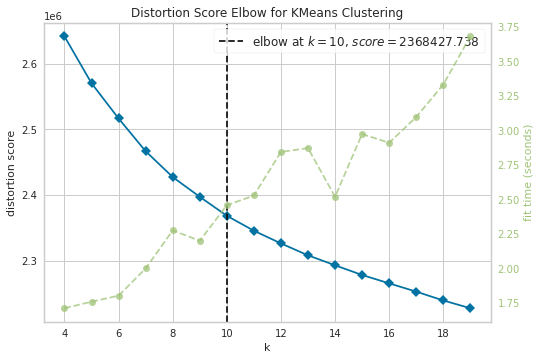

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clustersa
#X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(df_population_pca.sample(15000))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [30]:
n_best_num_kmeans_clusters = 9

In [31]:
from  python.model.kmeans import KMeansProcessor

In [32]:
kmeans = KMeansProcessor()
# use 10 cluster as calculated by the ellbow method
k_means_result = kmeans.fit_transform(df_population_pca, n_clusters=n_best_num_kmeans_clusters)

### Review segmentation



In [33]:
customer_labels = kmeans.model.predict(df_customers_pca)
customer_centroids = kmeans.model.cluster_centers_

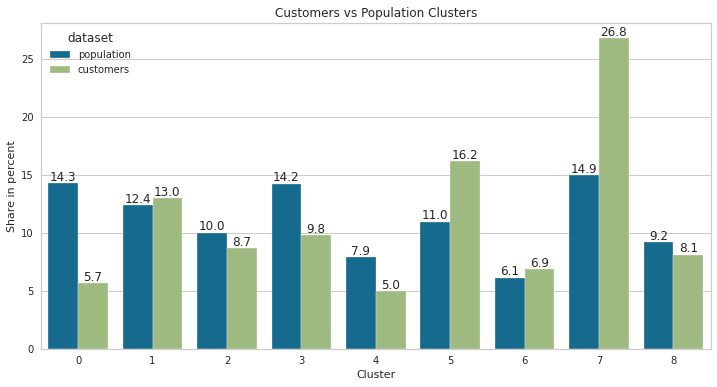

In [34]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_component_share = 100 * np.bincount(kmeans.pop_labels)/len(kmeans.pop_labels)
customer_component_share = 100 * np.bincount(customer_labels)/len(customer_labels)
component_shares = pd.DataFrame({'population':population_component_share,'customers':customer_component_share})
component_shares = component_shares.reset_index().melt(value_vars=['population','customers'],id_vars=['index'])
component_shares.rename(columns={'index':'component','variable':'dataset','value':'share'}, inplace=True)


#clusters = [x for x in range(0,n_best_num_kmeans_clusters)]
fig, ax = plt.subplots(1,1,figsize=(12,6))
#w=0.4
#sns.barplot(x=np.array(clusters)-0.2, height=customer_component_share, width=w , ax=ax)
sns.barplot(data=component_shares, x='component',y='share',hue='dataset',   ax=ax)
#sns.bar(x=np.array(clusters)+0.2, height=population_component_share, width=w, ax=ax)
plt.ylabel('Share in percent')
plt.xlabel('Cluster')
plt.xticks(range(0,n_best_num_kmeans_clusters))
plt.title('Customers vs Population Clusters')



for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

plt.show()

Customers are much more in component 6 (26.6% vs 17.7%) and little more in component 1,2,3 (~ 2% more).
General population main components are 4 and 7

I now check which features are the main drivers for that components.

In [35]:
centroids_df = pd.DataFrame(pca_reduced.pca.inverse_transform(customer_centroids), columns=df_customers_cleaned.columns)


In [36]:
centroids_df

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
0,0.471829,-0.021557,-0.064397,-0.210440,-0.040179,-0.044904,0.055369,0.128624,0.213106,-0.508094,...,0.411103,0.559656,-0.125005,-0.314531,-0.089520,0.541513,0.171429,-0.795899,0.067025,0.036133
1,-0.137121,-0.366210,-0.098235,-0.181577,-0.001008,-0.814744,0.433724,-0.669750,-0.508146,0.388615,...,0.206321,0.018345,0.289559,0.214585,0.488904,-0.389160,-0.344039,0.531625,-0.196824,-0.124368
2,-0.368362,-0.310047,-0.108910,0.615254,-0.041890,-0.380482,0.210140,-0.477517,0.376886,-0.817328,...,-0.741904,-0.351593,-0.929826,-0.301575,0.097399,-0.210448,-0.067184,-0.542635,0.964116,0.684664
3,0.231838,0.621011,0.071881,-0.312175,-0.060111,0.799894,-0.490550,1.022869,-0.022033,0.097069,...,0.313348,0.256210,0.230210,-0.090839,-0.237760,0.509249,-0.101515,-0.089768,-0.128060,-0.066132
4,-0.146278,-0.278249,-0.110777,-0.044702,-0.012906,0.551095,0.765624,-0.081569,-0.365963,0.230269,...,-0.215183,-0.375911,0.150736,0.111939,0.697941,-0.010890,-0.018900,0.348634,-0.113666,-0.078719
5,-0.639285,-0.282435,-0.021858,0.289590,0.068431,-0.031637,-0.078956,-0.479980,-0.348683,0.026265,...,-0.671912,-0.735159,0.124006,0.245018,-0.426231,-0.529458,0.255826,0.691531,-0.134879,-0.151237
6,-0.590911,-0.398461,-0.081119,1.427319,0.034943,-0.520087,0.392456,-0.650292,0.064464,-0.653274,...,-1.293707,-1.138800,-0.855904,0.493505,0.367890,-0.823227,-0.067970,0.228761,0.402326,0.032794
7,-0.002066,-0.064986,-0.055319,-0.549201,-0.052448,-0.045673,0.192633,0.249469,0.361371,0.664454,...,0.451763,0.285913,0.179388,0.366992,-0.396704,-0.073937,0.092596,0.102033,-0.301180,-0.139207
8,0.247679,0.528815,0.374533,-0.339340,0.160545,0.160659,-0.879498,0.423976,-0.087662,0.112637,...,0.379555,0.325968,0.292956,-0.111032,-0.470672,0.282845,-0.025776,0.035878,-0.146323,-0.053612


In [42]:
def show_component_details(dataset):
    n_max_disp = 3
    investigate_col_set_pos = set()
    investigate_col_set_neg = set()

    tdf = component_shares.pivot(columns='dataset', index='component')
    #tdf['diff'] = tdf['customer']-tdf['population']
    tdf = tdf.droplevel(axis=1, level=None)
    tdf['diff'] = tdf['population']-tdf['customers']

    ascending = dataset =='customers'
    tarr = tdf['diff'].sort_values(ascending = ascending).index[:n_max_disp]
    
    print(f'Dataset: {dataset}')
    for i, component_idx in enumerate(tarr):
        print('-'*50)
        print(f'Component: {component_idx}')
        print(f'Difference (population - customers) : {tdf.loc[component_idx,"diff"]:3.2f}%')
        print()
        max_pos_cols = centroids_df.iloc[component_idx,:].sort_values(ascending=False)[:3]
        for e in max_pos_cols.index:
            investigate_col_set_pos.add(e)
        
        max_neg_cols = centroids_df.iloc[component_idx,:].sort_values(ascending=False)[-3:]        
        for e in max_neg_cols.index:
            investigate_col_set_neg.add(e)
            
        print(max_pos_cols)        
        print()
        print(max_neg_cols)
        print()
        
    return investigate_col_set_pos, investigate_col_set_neg
        
cust_pos_cols, cust_neg_cols = show_component_details('customers')

Dataset: customers
--------------------------------------------------
Component: 7
Difference (population - customers) : -11.83%

KOMBIALTER           1.383789
D19_KONSUMTYP_MAX    0.806369
D19_GESAMT_DATUM     0.803378
Name: 7, dtype: float64

ONLINE_AFFINITAET   -0.616274
SEMIO_VERT          -0.735825
GEBURTSJAHR         -0.844670
Name: 7, dtype: float64

--------------------------------------------------
Component: 5
Difference (population - customers) : -5.19%

FINANZ_VORSORGER     0.892202
GREEN_AVANTGARDE     0.743720
FINANZ_MINIMALIST    0.742270
Name: 5, dtype: float64

CJT_TYP_2        -0.858316
RT_KEIN_ANREIZ   -0.887835
FINANZ_SPARER    -0.974815
Name: 5, dtype: float64

--------------------------------------------------
Component: 6
Difference (population - customers) : -0.75%

D19_BIO_OEKO           1.489972
D19_HAUS_DEKO          1.445385
LP_LEBENSPHASE_GROB    1.441306
Name: 6, dtype: float64

VK_DISTANZ                  -1.293707
D19_VERSAND_OFFLINE_DATUM   -1.512968
D1

### Population main cluster

In [43]:
pop_pos_cols, pop_neg_cols = show_component_details('population')

Dataset: population
--------------------------------------------------
Component: 0
Difference (population - customers) : 8.61%

CJT_TYP_1        0.873323
FINANZ_SPARER    0.865490
CJT_TYP_2        0.862299
Name: 0, dtype: float64

CJT_TYP_6   -0.838671
CJT_TYP_3   -0.919468
CJT_TYP_5   -0.986035
Name: 0, dtype: float64

--------------------------------------------------
Component: 3
Difference (population - customers) : 4.46%

KBA13_ANTG4     1.207874
PLZ8_ANTG4      1.177927
KBA13_BAUMAX    1.146724
Name: 3, dtype: float64

KBA13_AUTOQUOTE   -1.030938
KBA13_GBZ         -1.041800
KBA13_ANTG1       -1.145498
Name: 3, dtype: float64

--------------------------------------------------
Component: 4
Difference (population - customers) : 2.91%

OST_WEST_KZ        1.590658
KBA13_SITZE_5      1.557389
KBA13_HALTER_25    1.310501
Name: 4, dtype: float64

KBA13_SEG_OBEREMITTELKLASSE   -1.380908
KBA13_HERST_BMW_BENZ          -1.458212
KBA13_SITZE_4                 -1.460073
Name: 4, dtype: float

## compare values for some features

In [44]:
def plot_feature_diff (cols):
    n_chars_per_row=5
    meta_cols = df_metadata['Attribute'].unique()

    fig, axes = plt.subplots(len(cols) //n_chars_per_row+1, n_chars_per_row, figsize=(26,8))
    plt.subplots_adjust(hspace=0.8)

    for idx, col in enumerate(cols):
        r = pd.concat([df_population_cleaned[col].value_counts().sort_index()/df_population_cleaned[col].notnull().sum(),
               df_customers_cleaned[col].value_counts().sort_index()/df_customers_cleaned[col].notnull().sum()], join='inner', axis=1, keys=['pop','cust'])

        r.reset_index(inplace=True)
        r = r.melt(value_vars=['pop','cust'],id_vars=['index'])

        ax = axes[idx//n_chars_per_row,idx%n_chars_per_row]
        sns.barplot(x='index',y='value',hue='variable',data=r, ax=ax)    

        if col in meta_cols:
            try:
                mapping = df_metadata[(df_metadata['Attribute']==col)][['Value','Meaning']]
                mask = mapping['Meaning'] !='unknown'
                mapping['Value'] = mapping[mask]['Value'].astype('int')            
                mapping = mapping.set_index('Value').to_dict()

                #print(mapping)
                labels = ax.get_xticklabels()


                mapped_labels = []
                for label in labels:            
                    tval = label.get_text()             
                    tval = int(float(tval))
                    try:
                        mval = mapping['Meaning'][tval]
                        mapped_labels.append(mval[:20])
                    except:
                        mapped_labels.append(tval)

                ax.set_xticklabels(mapped_labels, rotation=90)
            except Exception as e:
                print(e)
                print(col)


        ax.set_ylabel('share')
        ax.set_xlabel('attribute value')

        #ax.set_xticklabels((np.arange(0,10)*10)[:n_labels])
        ax.set_title(col)
    
    

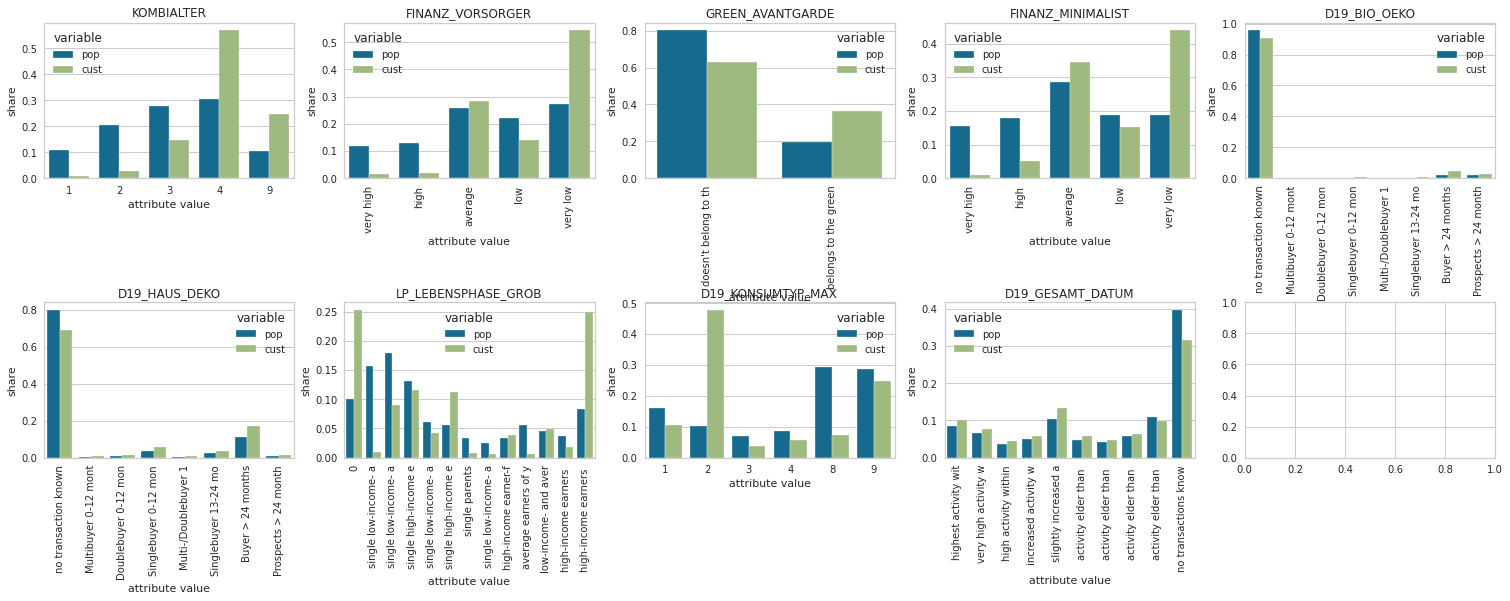

In [45]:
#len(cust_pos_cols) //5
plot_feature_diff(cust_pos_cols)

invalid literal for int() with base 10: '…'
GEBURTSJAHR


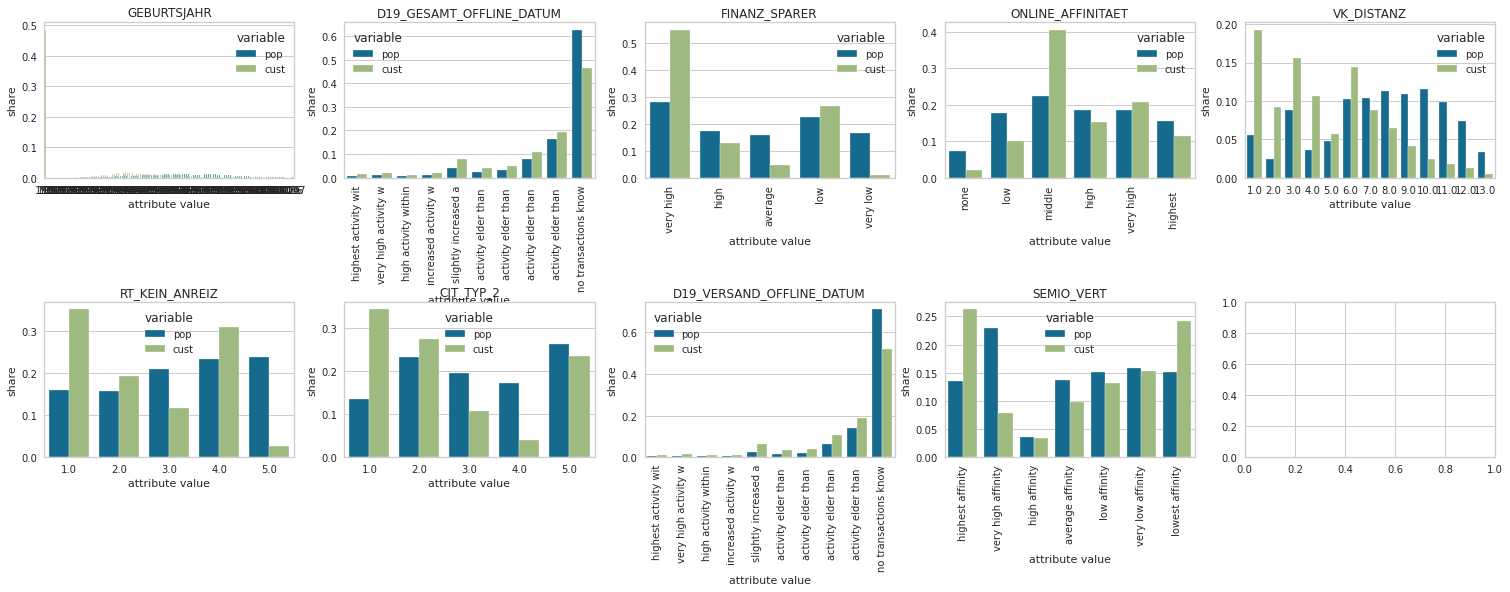

In [46]:
plot_feature_diff(cust_neg_cols)

invalid literal for int() with base 10: 'O'
OST_WEST_KZ


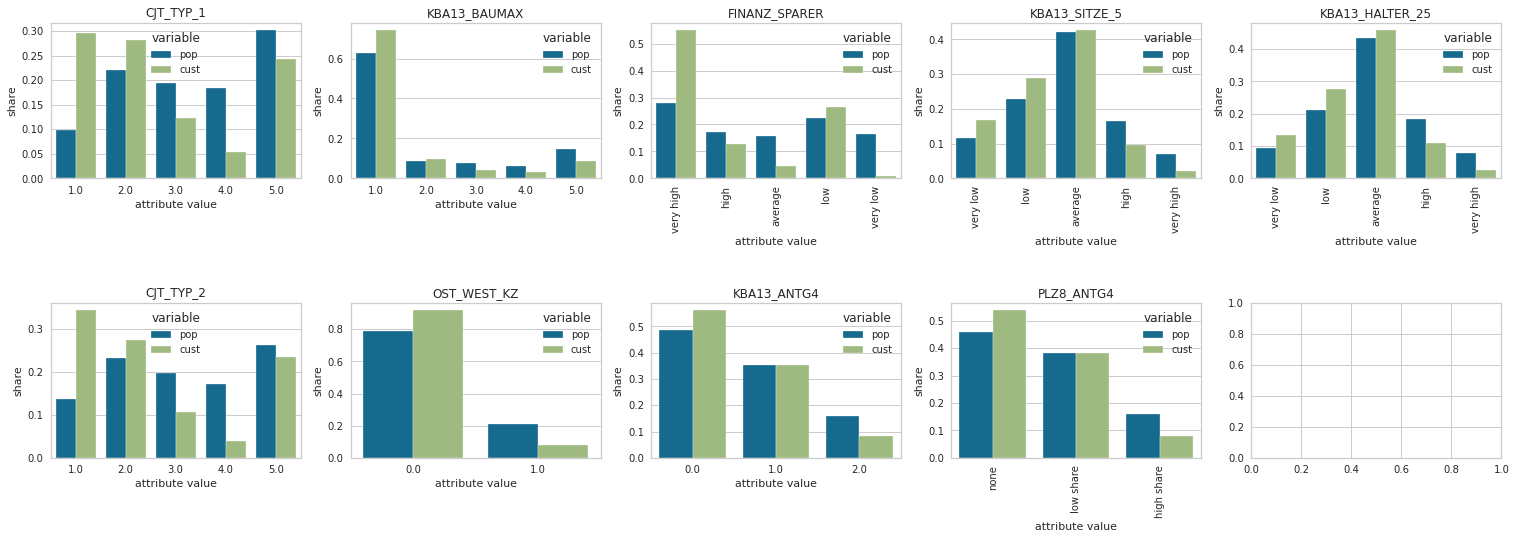

In [47]:
plot_feature_diff(pop_pos_cols)

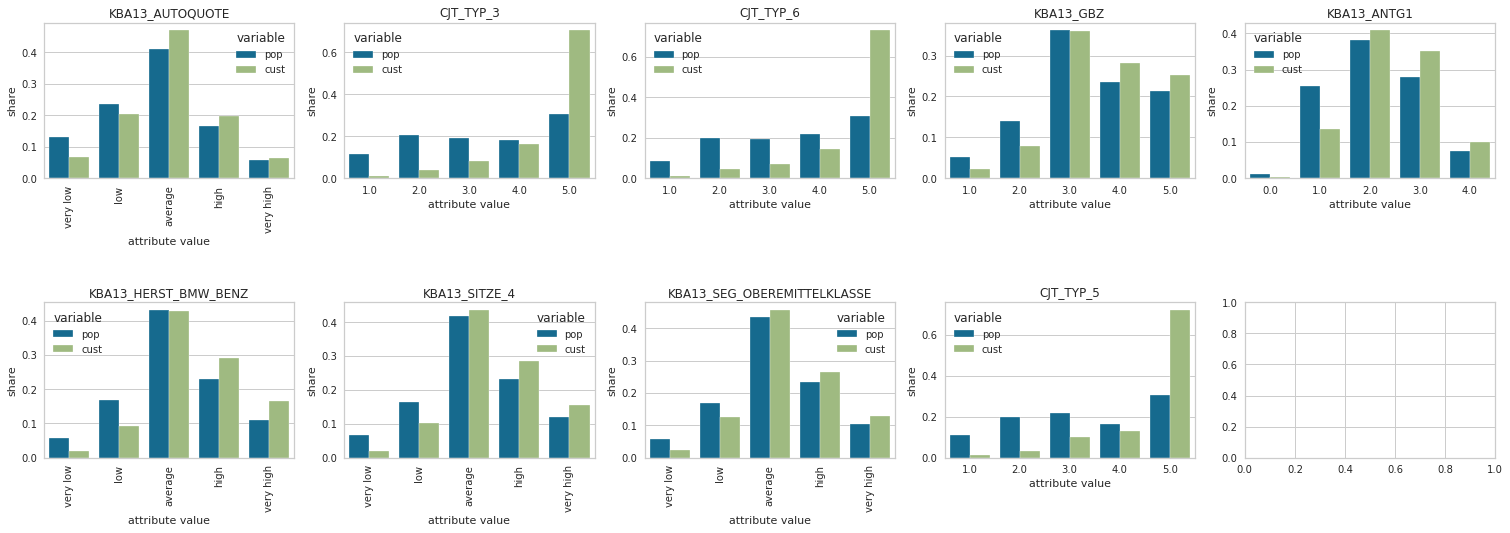

In [48]:
plot_feature_diff(pop_neg_cols)

# Part 2: Supervised Learning Model
---

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import progressbar

# magic word for producing visualizations in notebooka
%matplotlib inline

sns.set_theme()

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from python.etl.plot import Plot

In [5]:
sns.__version__


'0.11.2'

## Load Training and Test Data 

* load customer and population cleaned datasets
* load Mailout training and Test data
* preprocess mailout datasets 

In [6]:
import os
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    prefix = 's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'

In [7]:
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')

df_population_cleaned = pd.read_feather('df_azdias_cleaned')
df_customers_cleaned = pd.read_feather('df_customers_cleaned')

# set the index as feather-format did store the index as column
df_population_cleaned.set_index('LNR', inplace=True)
df_customers_cleaned.set_index('LNR', inplace=True)
df_population_cleaned.head(3)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,0,0
910220,9.0,11.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,1.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,0,0
910225,9.0,10.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,2.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,0,0


In [8]:
df_customers_cleaned.head(3)

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,1.0,0.0,2.0,0.0,1.0,3.0,1.0,5.0,4.0,...,3.0,2.0,6.0,9.0,7.0,3.0,1.0,4.0,0,0
9628,9.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,NaN,9.0,NaN,3.0,1.0,4.0,0,0
143872,1.0,1.0,0.0,1.0,0.0,3.0,7.0,5.0,2.0,5.0,...,13.0,11.0,6.0,9.0,2.0,3.0,2.0,4.0,0,0


In [9]:
df_mailout_train = pd.read_csv(f'{prefix}/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

#df_mailout_test = pd.read_csv(f'{prefix}/mailout_test.csv', index_col=False)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df_mailout_test = pd.read_csv(f'{prefix}/Udacity_MAILOUT_052018_TEST.csv', index_col=False, sep=';')

In [11]:
df_mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [12]:
print(df_mailout_train.shape)
print(df_population_cleaned.shape)
print(df_customers_cleaned.shape)

(42962, 367)
(891221, 323)
(191652, 323)


### Clean Mailout Data

In [13]:
import python.etl.processor as etlp
dfCleaner = etlp.PreDataCleaner(df_metadata)


df_mailout_train.set_index('LNR',inplace=True)
df_mailout_test.set_index('LNR',inplace=True)

df_mailout_train = dfCleaner.transform(df_mailout_train,drop_cols=True)
df_mailout_test = dfCleaner.transform(df_mailout_test,drop_cols=True)


fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 11
fixed column CAMEO_INTL_2015 - records fixed: 11
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']
replace unkown values by NaNs: 
 233 of 233	Processed columns	Processed columns	Processed columns
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}
dropping columns: ['EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'D19_VERSAND_ANZ_24', 'LP_LEBENSPHASE_FEIN', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'D19_VERSAND_ONLINE_DATUM', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_DATUM', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_SEG9', 'KBA13_KMH_211', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'EXTSEL992', 'KK_KUNDENTYP', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'D19_GESAMT

In [14]:
print(df_mailout_train.shape)
print(df_population_cleaned.shape)
print(df_customers_cleaned.shape)

(42962, 324)
(891221, 323)
(191652, 323)


## Mailout Segmentation
Let's make a comparison of the population, customer and mailout training data set

In [79]:
X_train = df_mailout_train.drop(['RESPONSE'], axis=1)
y_train = df_mailout_train['RESPONSE']
y_train = y_train.astype('int64')

X_test  = df_mailout_test



NameError: name 'pca' is not defined

In [80]:
df_mailout_train_pca = pca_reduced.transform(X_train)
df_mailout_test_pca = pca_reduced.transform(X_test)

In [81]:
#df_mailout_train_pca=df_mailout_train_pca[y[y==1]]
mailout_labels_train = kmeans.model.predict(df_mailout_train_pca)
mailout_labels_test = kmeans.model.predict(df_mailout_test_pca)
customer_centroids = kmeans.model.cluster_centers_

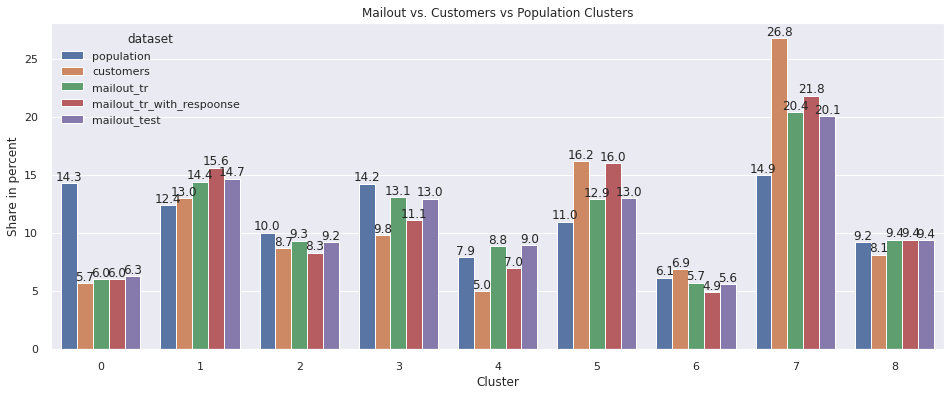

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_component_share = 100 * np.bincount(kmeans.pop_labels)/len(kmeans.pop_labels)
customer_component_share = 100 * np.bincount(customer_labels)/len(customer_labels)
# mailout no response
mailout_tr_component_share = 100 * np.bincount(mailout_labels_train[y_train==0])/len(mailout_labels_train[y_train==0])
# with response
mailout_tr_resp_component_share = 100 * np.bincount(mailout_labels_train[y_train==1])/len(mailout_labels_train[y_train==1])

mailout_tst_component_share = 100 * np.bincount(mailout_labels_test)/len(mailout_labels_test)

component_shares = pd.DataFrame({'population':population_component_share,'customers':customer_component_share, 
                                 'mailout_tr':mailout_tr_component_share, 'mailout_tr_with_respoonse':mailout_tr_resp_component_share,
                                'mailout_test':mailout_tst_component_share})
component_shares = component_shares.reset_index().melt(value_vars=['population','customers','mailout_tr', 'mailout_tr_with_respoonse','mailout_test'],id_vars=['index'])
component_shares.rename(columns={'index':'component','variable':'dataset','value':'share'}, inplace=True)


#clusters = [x for x in range(0,n_best_num_kmeans_clusters)]
fig, ax = plt.subplots(1,1,figsize=(16,6))
#w=0.4
#sns.barplot(x=np.array(clusters)-0.2, height=customer_component_share, width=w , ax=ax)
sns.barplot(data=component_shares, x='component',y='share',hue='dataset',   ax=ax)
#sns.bar(x=np.array(clusters)+0.2, height=population_component_share, width=w, ax=ax)
plt.ylabel('Share in percent')
plt.xlabel('Cluster')
#plt.xticks(rangeclusters)
plt.title('Mailout vs. Customers vs Population Clusters')



for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

plt.show()

## Split data to Train and Validation data

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

In [16]:
X = df_mailout_train.drop(['RESPONSE'], axis=1)
y = df_mailout_train['RESPONSE']
y=y.astype('int64')


In [17]:
# I use stratify = y to keep the ratio of responses in the split datasets
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

#### XGBClassifier - Testrun
just one small test

In [18]:
np.set_printoptions(suppress=True)

In [19]:
X_train.shape

(34369, 324)

In [20]:
xgb_clf = XGBClassifier(n_estimators = 30, max_depth=12)
xgb_clf.fit(X_train,y_train)
preds = xgb_clf.predict(X_val)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:59:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 1.0000


In [22]:
xgb_clf.predict_proba(X_val)

array([[0.99990803, 0.00009195],
       [0.99990803, 0.00009195],
       [0.99990803, 0.00009195],
       ...,
       [0.99990803, 0.00009195],
       [0.99990803, 0.00009195],
       [0.99990803, 0.00009195]], dtype=float32)

## GridSearch

### GridSearch Setup Parameters

In [23]:
scale_pos_weight = X_train.shape[0] / X_train[y_train==1].shape[0]
print(f'scale_pos_weight: {scale_pos_weight}')

parameters = [
    {
        'clf': [BalancedRandomForestClassifier()], # SVM if hinge loss / logreg if log loss
        'clf__n_estimators': [10,50,200],
        'clf__max_depth': [5, 15],
        'clf__n_jobs':[-1]
    },
    {
        'clf': [XGBClassifier(use_label_encoder=False)],
        'clf__use_label_encoder': [False],
        'clf__n_estimators': [10,50,200],
        'clf__max_depth' : [5,15],
        'clf__scale_pos_weight' : [1,scale_pos_weight],
        'clf__n_jobs':[-1]
    }
]

scale_pos_weight: 80.67840375586854


### Run GridSearch

In [24]:
n_sample_size=X_train.shape[0] #500

X_sample = X_train[:n_sample_size]
y_sample = y[:n_sample_size]

In [25]:
y_sample.value_counts()

0    33945
1      424
Name: RESPONSE, dtype: int64

In [28]:
# I use median as valmost all values are nominal or ordinal
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
min_max_scaler = MinMaxScaler()

#estimators = [('imputer', imputer), ('scaler',min_max_scaler), ('clf', RandomForestClassifier())]
estimators = [('imputer', imputer), ('clf', RandomForestClassifier())]
pipeline = Pipeline(estimators)

gscv = GridSearchCV(pipeline,parameters, verbose=4,  scoring='roc_auc', n_jobs=-1)

In [ ]:
gscv.fit(X_sample, y_sample)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [145]:
gscv.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=3,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=1, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'clf__max_depth': 3,
 'clf__n_jobs': -1,
 'clf__scale_pos_weight': 1}

In [146]:
gscv.best_score_

0.6712121212121213

In [149]:
best_clf = gscv.best_estimator_
best_predictions = best_clf.predict(X_val)
roc_auc_score(y_val, best_predictions)

0.49982325910215625

## Imbalanced Data

Handling heavy imbalanced data: see [Random Forest With Random Undersampling](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

In [131]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
# generate dataset
# define model
#model = BalancedRandomForestClassifier(n_estimators=50)
estimators = [('impute',imputer), ('scaler', min_max_scaler), ('clf', BalancedRandomForestClassifier(n_estimators=100))]
pipe = Pipeline(estimators)
pipe.fit(X,y)

model  = pipe.get_params('clf')['clf']
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.631


### XGBoost

see [XGBoost for imbanaced classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/)


scale_pos_weight = total_negative_examples / total_positive_examples

In [132]:
scale_pos_weight = X.shape[0] / X[y==1].shape[0]
scale_pos_weight

80.75563909774436

In [133]:
estimators = [('impute',imputer), ('scaler', min_max_scaler), ('clf', XGBClassifier())]
pipe2 = Pipeline(estimators)
pipe2.fit(X,y)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipe2, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:23:17] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean ROC AUC: 0.616


In [134]:
estimators = [('impute',imputer), ('scaler', min_max_scaler), ('clf', XGBClassifier(scale_pos_weight=scale_pos_weight))]
pipe3 = Pipeline(estimators)
pipe3.fit(X,y)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipe3, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:36:43] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean ROC AUC: 0.594


In [157]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) 

clf_final = XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500)

In [158]:
preds = clf_final.fit(X_train,y_train)

[08:44:25] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [160]:
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

0.7296131041704182


# Kaggle Submission

In [439]:
y_predict = pipe.predict_proba(df_mailout_test)

In [440]:
y_predict

array([[0.32, 0.68],
       [0.36, 0.64],
       [0.54, 0.46],
       ...,
       [0.46, 0.54],
       [0.42, 0.58],
       [0.68, 0.32]])

In [444]:
pd.DataFrame(index=df_mailout_test.index, data=y_predict[:, 1], columns=['RESPONSE']).to_csv(f"{prefix}/bauerst_prediction_2021_09_14_01.csv")

In [445]:
{prefix}/bauerst_prediction_2021_09_14_01.csv"

's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'

## Kaggle Submission 2

In [31]:
df_population_cleaned['RESPONSE']=0
df_customers_cleaned['RESPONSE']=1


In [32]:
# check if same individuals are in both data sets
set(df_population_cleaned.index).intersection(set(df_customers_cleaned.index))

set()

In [33]:
X_pop_cust = df_population_cleaned.append(df_customers_cleaned)
y_pop_cust = X_pop_cust['RESPONSE'].astype('int')
X_pop_cust = X_pop_cust.drop(columns='RESPONSE')

In [34]:
print(df_customers_cleaned.shape[0])
print(df_population_cleaned.shape[0])
print(df_population_cleaned.shape[0]+df_customers_cleaned.shape[0])
print(X_pop_cust.shape[0])

191652
891221
1082873
1082873


In [35]:
estimators = [('impute',imputer), ('scaler', min_max_scaler), ('clf', XGBClassifier())]
pipe4 = Pipeline(estimators)
pipe4.fit(X_pop_cust,y_pop_cust)

# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(pipe4, X_pop_cust, y_pop_cust, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.3f' % mean(scores))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:39:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=32, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [36]:
y_predict = pipe4.predict_proba(df_mailout_test)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [39]:
pd.DataFrame(index=df_mailout_test.index, data=y_predict[:, 1], columns=['RESPONSE']).to_csv(f"{prefix}/bauerst_prediction_2021_09_15-pipe4-01.csv")

In [41]:
estimators = [('impute',imputer), ('scaler', min_max_scaler), ('clf', RandomForestClassifier(n_estimators=100))]

X_pop_cust = pd.concat([X_pop_cust,X], axis=0)
y_pop_cust = pd.concat([y_pop_cust,y], axis=0)

pipe5 = Pipeline(estimators)
pipe5.fit(X_pop_cust,y_pop_cust)
y_predict = pipe4.predict_proba(df_mailout_test)
pd.DataFrame(index=df_mailout_test.index, data=y_predict[:, 1], columns=['RESPONSE']).to_csv(f"{prefix}/bauerst_prediction_2021_09_15-pipe5-01.csv")

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


## Kaggel Submission 3